In [1]:
import os, sys, shutil
import pathlib
import glob as glob
import numpy as np
import re
import warnings
import mdtraj as md
import pandas as pd
import dataframe_image as dfi
from itertools import combinations, combinations_with_replacement, product

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import barnaba as bb
import barnaba.cluster as cc

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import seaborn as sns
from IPython.display import display

In [2]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.precision = 1
pd.options.display.float_format = '{:.1f}'.format

In [3]:
plt.rcParamsDefault

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.grid.which':

In [4]:
params = {'legend.fontsize': 40, 
          'font.size': 40, 
          'axes.labelsize': 48,
          'axes.titlesize': 48,
          'xtick.labelsize': 40,
          'ytick.labelsize': 40,
          'savefig.dpi': 600, 
          'figure.figsize': [64, 8],
          'xtick.major.size': 10,
          'xtick.minor.size': 7,
          'ytick.major.size': 10,
          'ytick.minor.size': 7}

plt.rcParams.update(params)

In [5]:
sys.stderr = sys.__stderr__

# Loading /Users/takabak/work/rna_bgsu/pdb/motif//InternalLoopMotifAtlasRelease3.57/triplebase/IL_98353.1_GGG_7.pdb 
# Loading /Users/takabak/work/rna_bgsu/pdb/motif//InternalLoopMotifAtlasRelease3.57/triplebase/IL_98353.1_GGG_7.pdb 
# Loading /Users/takabak/work/rna_bgsu/pdb/motif//InternalLoopMotifAtlasRelease3.57/triplebase/IL_98353.1_GGG_7.pdb 
# Loading /Users/takabak/work/rna_bgsu/pdb/motif//InternalLoopMotifAtlasRelease3.57/triplebase/IL_69979.1_GGG_3.pdb 
# Loading /Users/takabak/work/rna_bgsu/pdb/motif//InternalLoopMotifAtlasRelease3.57/triplebase/IL_69979.1_GGG_3.pdb 
# Loading /Users/takabak/work/rna_bgsu/pdb/motif//InternalLoopMotifAtlasRelease3.57/triplebase/IL_69979.1_GGG_3.pdb 
# Loading /Users/takabak/work/rna_bgsu/pdb/motif//HairpinLoopMotifAtlasRelease3.57/triplebase/HL_75091.3_GGG_6.pdb 
# Loading /Users/takabak/work/rna_bgsu/pdb/motif//HairpinLoopMotifAtlasRelease3.57/triplebase/HL_75091.3_GGG_6.pdb 
# Loading /Users/takabak/work/rna_bgsu/pdb/motif//HairpinLoopMotif

In [6]:
def load_file(files, dump_path):
    """
    Load pdb files as trajectory 
    
    Parameters
    ----------
    files :
        PDB files in full path
    dump_path :
        Full path pointing to the dump directory to store deleted PDB files from the trajectory list

    Returns
    -------
    trajs : list of obj
        List of trajectory object loaded by MDTraj
    """ 
    # load files and get maximum number of atoms and residues within the file
    trajs = [ md.load_pdb(f) for f in files ]    
    n_atoms = [ traj.topology.n_atoms for traj in trajs ]
    n_residues = [ traj.topology.n_residues for traj in trajs ]
    max_atoms = max(n_atoms)
    max_residues = max(n_residues)
    #print(n_atoms.index(max_atom)])

        
    # check atom numbers
    indexes = []
    for i, traj in enumerate(trajs):
        if max_atoms != traj.topology.n_atoms or max_residues != traj.topology.n_residues:
            print("{} removed from list".format(os.path.basename(files[i])))
            if max_atoms != traj.topology.n_atoms:
                print("Missing atoms? Expected number of atoms: {} / Actual number of atoms: {}".format(max_atoms, traj.topology.n_atoms))
            if max_residues != traj.topology.n_residues:
                print("Duplicate residue numbers? Expected number of residues: {} / Actual number of residues: {}".format(max_residues, traj.topology.n_residues))
            shutil.copy(files[i], dump_path)
            indexes.append(i)
            

    # delete files
    if indexes != []:
        for index in sorted(indexes, reverse=True):
            #print("delete index #{}".format(index))
            #del trajs[index]
            del files[index]  
 
    return files

In [7]:
def psuedo_angles(file):
    traj = md.load_pdb(file)
    residues = [ residue for residue in traj.topology.residues ]

    r_minus = residues[0] 
    r = residues[1]
    r_plus = residues[2]

    idx_theta = [ r_minus.atom("C4'").index, r.atom("P").index, r.atom("C4'").index, r_plus.atom("P").index ]
    idx_eta = [ r.atom("P").index, r.atom("C4'").index, r_plus.atom("P").index, r_plus.atom("C4'").index ]

    p1 = float(md.compute_dihedrals(traj, np.array(idx_theta).reshape(1,4)))
    p2 = float(md.compute_dihedrals(traj, np.array(idx_eta).reshape(1,4)))

    angles_psuedo = np.array([p1, p2])
    
    return angles_psuedo

In [8]:
def dist_featurizer(curated_files, atom_slice_interval):
    """
    Calculate internal atom distances
    """

    trajs = [ md.load_pdb(f) for f in curated_files ]    
    
    # case 1)
    #atom_indices = [ a.index for a in trajs[0].topology.atoms ]
    #atom_pairs = list(combinations(atom_indices[::atom_slice_interval], 2))
    
    # case 2)
    #atom_indices = [ a.index for a in trajs[0].topology.atoms if a.element.symbol is not 'C' ]
    #atom_pairs = list(combinations(atom_indices[::atom_slice_interval], 2))

    # case 3)
    atom_indices = [ a.index for a in trajs[0].topology.atoms if (a.name == "P" or a.name == "O2'" or a.name == "O3'" or a.name == "O4'" or a.name == "N2" or a.name == "N4" or a.name == "N6" or a.name == "O2" or a.name == "O4" or a.name == "O6") ] 
    atom_pairs = list(combinations(atom_indices, 2))
    
    #for _ in atom_indices[::atom_slice_interval]:
    #    print("{}".format(trajs[0].topology.atom(_)))
    
    feat = [ md.compute_distances(traj, atom_pairs, periodic=False, opt=True)[0] for traj in trajs ]
    feat = np.array(feat)
    
    return feat

In [9]:
def torsion_featurizer(curated_files):
    """
    Calculate 6 torsion angles (α, β, γ, δ, ε, and ζ) around the consecutive chemical bonds, chi (χ) quantifying the relative base/sugar orientation, plus the sugar pucker.
    https://x3dna.org/highlights/pseudo-torsions-to-simplify-the-representation-of-dna-rna-backbone-conformation
    
    """    
    # step1) calculate torsions
    arr = []
    for file in curated_files:        
        angles_bb, res = bb.backbone_angles(file)  # backbone torsion and sugar/base torsion
        angles_s, res = bb.sugar_angles(file)      # sugar torsion
        angles_p, res = bb.pucker_angles(file)     # pucker angle
        angles_psuedo = psuedo_angles(file)        # psuedo angle

        # concatenate backbone, sugar, and pucker torsions
        _angles = np.concatenate((angles_bb[0], angles_s[0]), axis=1)
        angles = np.concatenate((_angles, angles_p[0]), axis=1)  

        # concatenate psuedo torsions
        angles = angles.flatten()
        angles = np.concatenate((angles, angles_psuedo))        
        arr.append(angles)


    # step2) find array index with nan
    a = []
    arr = np.array(arr)    
    for x in arr:
        a.append(np.argwhere(np.isnan(x)))
    a = np.array(a)
    a = a.flatten()
    nan_indexes = set(a)
    
    # step3) remove nan from torsion array
    feat = []
    for a in arr:
        for i in sorted(nan_indexes, reverse=True):
            #print(i)
            a = np.delete(a, i)
        feat.append(a)
    feat = np.array(feat)
    feat = np.rad2deg(feat)
    
    return feat

In [10]:
def dbscan_cluster(feat, params):
    """
    """
    cluster = DBSCAN(eps=params["eps"], min_samples=2).fit(feat)    
    print(cluster.labels_)

    clf = NearestCentroid()
    clf.fit(feat, cluster.labels_)
    centroid_feat = clf.centroids_
    #centroid_indexes = find_cluster_centroid(centroid_feat, feat, cluster.labels_)
    centroid_indexes = find_cluster_centroid_within_cluster(centroid_feat, feat, cluster.labels_)
    
    return cluster.labels_, centroid_indexes

In [11]:
def agglomerative_cluster(feat, params):
    """
    Agglomerative clustering (bottom-up hierarchical clustering)
    
    Parameters
    ----------
    feat : numpy array of float
        Numpy array of features
    params : dictionary
        Clustering parameters

    Returns
    -------
    cluster.labels_ : list of int
        List of cluster id
    centroid_indexes : list of int
        List index pointing to the nearest centroid coordinates
    """
        
    # https://aiaspirant.com/hierarchical-clustering/
    cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=params["threshold"], compute_distances=True, linkage=params["method"], affinity="euclidean").fit(feat)    
    if len(set(cluster.labels_)) == 1:
        print("Only one cluster defined. Set n_clusters to 2")
        cluster = AgglomerativeClustering(n_clusters=2, compute_distances=True, linkage=params["method"], affinity="euclidean").fit(feat)    

    clf = NearestCentroid()
    clf.fit(feat, cluster.labels_)
    centroid_feat = clf.centroids_
    #centroid_indexes = find_cluster_centroid(centroid_feat, feat, cluster.labels_)
    centroid_indexes = find_cluster_centroid_within_cluster(centroid_feat, feat, cluster.labels_)
    
    return cluster.labels_, centroid_indexes

In [12]:
def find_cluster_centroid_within_cluster(centroid_feat, feat, cluster_labels):
    """
    Find cluster centroid
    
    Parameters
    ----------
    centroid_feat : array
        Array of centroid features
    feat : array
        Array of internal distances obtained from list of trajectories
    cluster_labels : list of int
        List of cluster id

    Returns
    -------
    centroid_indexes : list of int
        List index pointing to the nearest centroid coordinates within each cluster
    """    
    centroid_indexes = []
    
    for cluster_id in range(len(centroid_feat)):
        indexes = np.where(cluster_labels == cluster_id)[0]
        _feat = [ feat[index] for index in indexes ]
        
        arr = []
        for d in _feat:
            v = 0
            delta = d - centroid_feat[cluster_id]
            for x in delta:
                v += np.square(x)
            arr.append(np.sqrt(v))

        arr = np.array(arr)
        i = np.where(arr==arr.min())  

        # e.g. i --> (array([323, 378]),)                    
        if len(i[0]) != 1:  
            ncls = len(indexes)
            if ncls != 2:
                print("cluster #{}: Found {} samples but more than one index was assigned as centroid ({})".format(i, ncls, cluster_id))
                print("array: {}".format(arr))
                print("centroid_feature: {}".format(centroid_feat[cluster_id]))
                print("feature1: {}".format(feat[i[0][0]]))
                print("feature2: {}".format(feat[i[0][1]]))
            i = int(i[0][0])
        else:
            i = int(i[0])
        
        index = indexes[i]
        centroid_indexes.append(index)

       
    return centroid_indexes

In [13]:
def find_cluster_centroid(centroid_feat, feat, cluster_labels):
    """
    Find cluster centroid
    
    Parameters
    ----------
    centroid_feat : array
        Array of centroid features
    feat : array
        Array of internal distances obtained from list of trajectories
    cluster_labels : list of int
        List of cluster id

    Returns
    -------
    centroid_indexes : list of int
        List index pointing to the nearest centroid coordinate
    """    
    centroid_indexes = []
    
    for cid in range(len(centroid_feat)):
        arr = []
        for i in range(len(feat)):
            v = 0
            delta = feat[i] - centroid_feat[cid]
            for x in delta:
                v += np.square(x)
            #arr.append(np.sqrt(v))
            arr.append(v)

        arr = np.array(arr)
        i = np.where(arr==arr.min())  

        # More than one index could be assigned as centroids if the number of samples within the cluster is only 2
        # since the centroid coordinate will be the averaged coordinate of the two samples
        # e.g. i --> (array([323, 378]),)            
        if len(i[0]) != 1: 
            ncls = len(np.where(cluster_labels == cid)[0])
            if ncls != 2:
                print("cluster #{}: Found {} samples but more than one index was assigned as centroid ({})".format(i, ncls, cid))
                print("array: {}".format(arr))
                print("centroid_feature: {}".format(centroid_feat[cid]))
                print("feature1: {}".format(feat[i[0][0]]))
                print("feature2: {}".format(feat[i[0][1]]))
            i = int(i[0][0])
        else:
            i = int(i[0])
        
        centroid_indexes.append(i)

       
    return centroid_indexes

In [14]:
def export_pdb(files, cluster_labels, centroid_indexes, dest_path):
    """
    Export centroid structures in PDB format
    """
    
    os.makedirs(os.path.join(dest_path, "centroid"), exist_ok = True)
    centroid_filenames = [ os.path.basename(files[index]) for index in centroid_indexes ]
    
    
    # loop over each cluster
    for cluster_id in set(cluster_labels):
        cluster_path = os.path.join(dest_path, "cluster_{}".format(cluster_id))
        os.makedirs(cluster_path, exist_ok = True)
        
        # find structures corresponding to cluster X
        indexes = np.where(cluster_labels == cluster_id)[0]
        filenames = [ os.path.basename(files[index]) for index in indexes ]
        trajs = [ md.load_pdb(files[index]) for index in indexes ]
        
        # find centroid structure corresponding to cluster X
        ref = list(set(centroid_filenames).intersection(filenames))
        assert len(ref) == 1, "found more than one reference: {}".format(ref)

        ref_traj = [ md.load_pdb(file) for file in files if os.path.basename(file) == ref[0] ][0]
        ref_file = [ file for file in files if os.path.basename(file) == ref[0] ][0]
        shutil.copy(ref_file, os.path.join(os.path.join(dest_path, "centroid", "rep{}__".format(cluster_id) + ref[0])))

        # calculate rmsd respect to centroid structure
        val = []
        for i, traj in enumerate(trajs):
            traj.superpose(ref_traj, 0)   
            rmsd = md.rmsd(traj, ref_traj, 0) * 10.  # nanometers -> angstroms    
            #print("mdtraj: {}".format(rmsd))
            
            val.append(rmsd[0])
            traj.save_pdb(os.path.join(cluster_path, filenames[i]))
            
        with open(os.path.join(cluster_path, "rmsd.dat"), "w") as wf:
            wf.write("# reference structure: {}\n".format(ref[0]))
            for i, v in enumerate(val):
                if ref[0] == filenames[i]:
                    name = "REF"
                else:
                    name = filenames[i]
                wf.write("{}\t{}\n".format(v, name))
                
                        
    # make pymol script for future aligment
    _path = os.path.join(dest_path, "centroid")
    fs = glob.glob(_path + "/rep*.pdb")
    with open(os.path.join(_path + "/script.pml"), "w") as wf:
        for f in fs:
            basename = os.path.basename(f)
            basename_noext = os.path.splitext(basename)[0]
            wf.write("align {}, obj01\n".format(basename_noext))
            
    return len(fs)

In [15]:
def get_basesets(categories):
    """
    Generate base sequence
    """
    base_set = "GCAU"    
    arr = []
    for a in list(product(base_set, repeat=n)):
        seq = ''.join(a)
        arr.append(seq)
            
    return arr

In [18]:
def plot(cluster_path, seq):
    
    ncls = len(glob.glob(cluster_path + "/cluster_*"))
    print("{} clusters".format(ncls))
    
    mydict = {}
    c_id, c_num, r_avg, r_std, r_max, r_min = [], [], [], [], [], []
    arr = []
    for i in range(ncls):
        rmsdfile = os.path.join(cluster_path, "cluster_{}".format(i), "rmsd.dat")
        
        r = []
        with open(rmsdfile, "r") as f:
            for l in f.readlines()[1:]:
                v = l.split('\t')[0]
                if v != 0:
                    r.append(float(v))
                    arr.append([i, v])
        
        c_id.append(i)
        c_num.append(len(r))
        
        r = np.array(r)
        r_avg.append(np.mean(r))
        r_std.append(np.std(r))
        r_max.append(np.max(r))
        r_min.append(np.min(r))
        
    mydict = {"# of samples": c_num, "Avg": r_avg, "Std": r_std, "Max": r_max, "Min": r_min}
    
    df = pd.DataFrame.from_dict(mydict, dtype=float)
    display(df.T)
        
    df = pd.DataFrame(arr, columns=["Cluster", "RMSD"], dtype=float)
    df_select = df.query( 'Cluster<100' )
    df_select['Cluster'] = df_select['Cluster'].astype('int')

    plt.clf()
    fig, ax = plt.subplots(figsize=(32, 8))
    ax = sns.violinplot(data=df_select, inner="points", x="Cluster", y ="RMSD")
    ax.set_title(seq)
    
    # x-label
    ax.xaxis.set_ticks(np.arange(0, ncls, 5))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlim([-0.9, ncls-0.1]) 
    
    # y-label
    ax.set_ylabel(r'RSMD [${\rm \AA}$]')
    ax.yaxis.set_ticks(np.arange(-3, 4, 3))
    #ax.yaxis.set_minor_locator(MultipleLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_ylim([-3.5, 3.5])
    
    plt.tight_layout()
    #plt.show()
    
    # save
    df.to_csv(os.path.join(cluster_path, 'summary_{}.csv'.format(seq)))
    #dfi.export(df.T, os.path.join(cluster_path, 'summary_{}.png'.format(seq)))
    #dfi.export(df.T, os.path.join(cluster_path, 'summary_{}.eps'.format(seq)))
    plt.savefig(os.path.join(cluster_path, 'violoin_{}.png'.format(seq)))
    plt.savefig(os.path.join(cluster_path, 'violoin_{}.eps'.format(seq)))

GGG: 99 files found
50 clusters


0    1   2   3    4   5   6   7   8   9   10  11  12  13  14  \
# of samples 2.0 29.0 2.0 2.0 11.0 2.0 3.0 1.0 1.0 2.0 3.0 1.0 1.0 1.0 1.0   
Avg          0.6  0.6 0.5 0.1  0.4 0.4 0.2 0.0 0.0 0.2 0.2 0.0 0.0 0.0 0.0   
Std          0.6  0.2 0.5 0.1  0.2 0.4 0.1 0.0 0.0 0.2 0.3 0.0 0.0 0.0 0.0   
Max          1.2  1.2 0.9 0.1  0.8 0.8 0.3 0.0 0.0 0.5 0.6 0.0 0.0 0.0 0.0   
Min          0.0  0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 1.0 1.0 1.0 1.0 1.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  
# of samples 1.0 1.0 1.0  
Avg          0.0 0.0 0.0  
Std          0.0 0.0 0.0  
Max          0.0 0.0 0.0  
Min          0.0 0.0 0.0

GGC: 138 files found
59 clusters


0   1   2    3   4   5   6   7   8   9   10  11  12  13  14  \
# of samples 22.0 2.0 2.0 36.0 9.0 2.0 3.0 2.0 2.0 1.0 5.0 2.0 1.0 3.0 2.0   
Avg           0.7 0.5 0.2  0.4 0.4 0.1 0.2 0.1 0.2 0.0 0.1 0.0 0.0 0.1 0.1   
Std           0.3 0.5 0.2  0.2 0.2 0.1 0.1 0.1 0.2 0.0 0.1 0.0 0.0 0.1 0.1   
Max           1.2 1.0 0.3  0.7 0.6 0.2 0.3 0.1 0.5 0.0 0.2 0.1 0.0 0.3 0.1   
Min           0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

GGA: 282 files found
100 clusters


0   1   2    3   4   5   6   7   8   9   10  11  12  13   14  \
# of samples 5.0 3.0 8.0 16.0 4.0 8.0 2.0 6.0 1.0 2.0 2.0 4.0 7.0 5.0 16.0   
Avg          0.8 0.6 0.5  0.6 0.6 0.7 0.6 0.5 0.0 0.5 0.7 0.8 0.5 0.8  0.2   
Std          0.6 0.7 0.5  0.4 0.4 0.3 0.6 0.2 0.0 0.5 0.7 0.5 0.2 0.4  0.1   
Max          1.5 1.6 1.4  1.3 1.1 1.0 1.2 0.8 0.0 0.9 1.4 1.4 0.6 1.2  0.4   
Min          0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0   

              15  16  17  18  19  20   21   22   23  24  25  26   27  28  29  \
# of samples 2.0 2.0 1.0 1.0 4.0 5.0 15.0 11.0 13.0 8.0 2.0 1.0 15.0 2.0 2.0   
Avg          0.7 0.1 0.0 0.0 0.4 0.2  0.3  0.6  0.5 0.4 0.1 0.0  0.3 0.0 0.2   
Std          0.7 0.1 0.0 0.0 0.3 0.1  0.2  0.3  0.2 0.2 0.1 0.0  0.2 0.0 0.2   
Max          1.3 0.1 0.0 0.0 0.6 0.2  0.6  1.1  0.7 0.6 0.1 0.0  0.8 0.1 0.3   
Min          0.0 0.0 0.0 0.0 0.0 0.0  0.0  0.0  0.0 0.0 0.0 0.0  0.0 0.0 0.0   

              30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  \
# of samples 1.0 2.0 4.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 5.0 9.0 1.0   
Avg          0.0 0.2 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.0 0.0 0.2 0.3 0.0   
Std          0.0 0.2 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.0 0.0 0.1 0.1 0.0   
Max          0.0 0.4 0.8 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.9 0.0 0.0 0.4 0.5 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  \
# of samples 2.0 1.0 2.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.5 0.0 0.1 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0   
Std          0.5 0.0 0.1 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0   
Max          1.0 0.0 0.3 0.8 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  \
# of samples 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

               94  95  96  97  98  99  
# of samples 17.0 1.0 1.0 1.0 1.0 1.0  
Avg           0.3 0.0 0.0 0.0 0.0 0.0  
Std           0.1 0.0 0.0 0.0 0.0 0.0  
Max           0.4 0.0 0.0 0.0 0.0 0.0  
Min           0.0 0.0 0.0 0.0 0.0 0.0

GGU: 133 files found
76 clusters


0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
# of samples 20.0 2.0 3.0 3.0 3.0 6.0 4.0 4.0 3.0 2.0 1.0 1.0 5.0 4.0 2.0 1.0   
Avg           0.6 0.6 0.6 0.5 0.4 0.3 0.4 0.4 0.4 0.3 0.0 0.0 0.4 0.4 0.1 0.0   
Std           0.2 0.6 0.5 0.4 0.5 0.2 0.3 0.3 0.3 0.3 0.0 0.0 0.2 0.3 0.1 0.0   
Max           0.9 1.3 1.1 1.1 1.0 0.8 0.8 0.7 0.8 0.6 0.0 0.0 0.7 0.8 0.2 0.0   
Min           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  \
# of samples 6.0 2.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 1.0 1.0 1.0   
Avg          0.1 0.1 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.3 0.0 0.0 0.0   
Std          0.1 0.1 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.3 0.0 0.0 0.0   
Max          0.2 0.1 0.0 0.0 0.6 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.7 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              64  65  66  67  68  69  70  71  72  73  74  75  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

GCG: 388 files found
87 clusters


0    1    2   3   4   5    6   7   8   9   10  11  12  13  14  \
# of samples 57.0 96.0 16.0 9.0 2.0 4.0 10.0 2.0 3.0 7.0 4.0 4.0 4.0 2.0 2.0   
Avg           0.7  0.4  0.5 0.5 0.4 0.4  0.3 0.4 0.3 0.6 0.2 0.3 0.2 0.5 0.4   
Std           0.2  0.2  0.2 0.3 0.4 0.3  0.2 0.4 0.4 0.3 0.1 0.3 0.1 0.5 0.4   
Max           1.0  0.8  0.7 0.9 0.8 0.8  0.8 0.8 0.9 0.9 0.3 0.7 0.3 1.0 0.8   
Min           0.0  0.0  0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              15  16   17   18  19  20  21  22  23  24  25  26  27  28  29  \
# of samples 9.0 3.0 10.0 12.0 7.0 2.0 4.0 6.0 1.0 2.0 1.0 2.0 1.0 1.0 8.0   
Avg          0.3 0.1  0.3  0.3 0.4 0.5 0.1 0.2 0.0 0.2 0.0 0.1 0.0 0.0 0.3   
Std          0.2 0.1  0.2  0.2 0.2 0.5 0.1 0.1 0.0 0.2 0.0 0.1 0.0 0.0 0.2   
Max          0.6 0.2  0.6  0.6 0.6 1.1 0.2 0.4 0.0 0.4 0.0 0.2 0.0 0.0 0.5   
Min          0.0 0.0  0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              30   31  32  33  34  35  36  37   38  39  40  41  42  43  44  \
# of samples 1.0 18.0 1.0 3.0 1.0 1.0 1.0 2.0 11.0 1.0 4.0 1.0 3.0 1.0 1.0   
Avg          0.0  0.5 0.0 0.0 0.0 0.0 0.0 0.2  0.3 0.0 0.2 0.0 0.3 0.0 0.0   
Std          0.0  0.3 0.0 0.0 0.0 0.0 0.0 0.2  0.2 0.0 0.1 0.0 0.3 0.0 0.0   
Max          0.0  0.8 0.0 0.0 0.0 0.0 0.0 0.3  0.6 0.0 0.3 0.0 0.6 0.0 0.0   
Min          0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 2.0 3.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.2   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.2   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.1 0.4   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              77  78  79  80  81  82  83  84  85  86  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

GCC: 122 files found
49 clusters


0   1   2   3   4   5   6    7   8   9   10  11  12  13  14  \
# of samples 15.0 9.0 2.0 3.0 9.0 4.0 8.0 11.0 1.0 2.0 3.0 1.0 2.0 1.0 1.0   
Avg           0.5 0.6 0.7 0.5 0.4 0.1 0.6  0.3 0.0 0.3 0.5 0.0 0.1 0.0 0.0   
Std           0.3 0.3 0.7 0.3 0.3 0.1 0.3  0.2 0.0 0.3 0.4 0.0 0.1 0.0 0.0   
Max           1.0 1.1 1.4 0.8 0.8 0.2 1.0  0.6 0.0 0.6 0.8 0.0 0.2 0.0 0.0   
Min           0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 1.0 7.0 1.0 1.0 2.0 6.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.2 0.0 0.0 0.1 0.2 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.1 0.0 0.0 0.1 0.1 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.3 0.0 0.0 0.2 0.4 0.0 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 3.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.3   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.2   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.4   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  
# of samples 1.0 1.0  
Avg          0.0 0.0  
Std          0.0 0.0  
Max          0.0 0.0  
Min          0.0 0.0

GCA: 255 files found
82 clusters


0    1   2   3    4    5    6   7   8   9   10  11   12  13  \
# of samples 23.0 14.0 9.0 2.0 21.0 12.0 14.0 2.0 5.0 3.0 3.0 5.0 11.0 1.0   
Avg           0.8  0.7 0.4 0.7  0.5  0.6  0.4 0.6 0.5 0.4 0.3 0.4  0.5 0.0   
Std           0.3  0.3 0.3 0.7  0.3  0.2  0.2 0.6 0.2 0.3 0.3 0.2  0.3 0.0   
Max           1.2  1.2 1.1 1.3  1.0  0.9  0.9 1.2 0.7 0.6 0.7 0.7  0.9 0.0   
Min           0.0  0.0 0.0 0.0  0.0  0.0  0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0   

              14  15  16  17  18  19  20  21  22  23  24  25   26  27  28  29  \
# of samples 3.0 4.0 2.0 6.0 1.0 5.0 1.0 3.0 1.0 1.0 1.0 1.0 19.0 1.0 1.0 3.0   
Avg          0.2 0.5 0.6 0.2 0.0 0.2 0.0 0.2 0.0 0.0 0.0 0.0  0.5 0.0 0.0 0.2   
Std          0.3 0.3 0.6 0.1 0.0 0.1 0.0 0.2 0.0 0.0 0.0 0.0  0.3 0.0 0.0 0.2   
Max          0.6 1.0 1.2 0.3 0.0 0.2 0.0 0.4 0.0 0.0 0.0 0.0  1.2 0.0 0.0 0.4   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0   

               30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  \
# of samples 11.0 6.0 5.0 2.0 1.0 1.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 1.0   
Avg           0.5 0.1 0.4 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.3 0.0   
Std           0.3 0.1 0.4 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.3 0.0   
Max           0.8 0.2 1.2 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.6 0.0   
Min           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  \
# of samples 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              78  79  80  81  
# of samples 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0

GCU: 176 files found
59 clusters


0   1    2   3   4   5   6    7   8   9    10  11  12  13  14  \
# of samples 2.0 4.0 23.0 2.0 4.0 2.0 9.0 10.0 2.0 2.0 12.0 2.0 3.0 2.0 1.0   
Avg          0.4 0.4  0.6 0.6 0.5 0.4 0.5  0.3 0.3 0.4  0.2 0.3 0.4 0.1 0.0   
Std          0.4 0.3  0.3 0.6 0.4 0.4 0.2  0.2 0.3 0.4  0.1 0.3 0.3 0.1 0.0   
Max          0.9 0.8  1.2 1.2 0.9 0.8 0.7  0.6 0.7 0.8  0.5 0.5 0.7 0.1 0.0   
Min          0.0 0.0  0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 1.0 1.0 3.0 1.0 7.0 9.0 1.0 1.0 4.0 2.0 2.0 2.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.1 0.0 0.1 0.5 0.0 0.0 0.0 0.1 0.2 0.4 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.1 0.0 0.1 0.3 0.0 0.0 0.0 0.1 0.2 0.4 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.3 0.0 0.3 0.9 0.0 0.0 0.0 0.1 0.5 0.8 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53   54  55  56  57  58  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 31.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.6 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.3 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0  1.2 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0

GAG: 239 files found
102 clusters


0    1    2    3    4    5    6    7    8    9    10   11   12   \
# of samples  2.0  4.0  9.0  4.0  2.0 11.0  3.0  4.0  7.0 17.0  6.0  5.0  2.0   
Avg           0.6  0.7  0.4  0.6  0.5  0.4  0.5  0.3  0.4  0.5  0.5  0.6  0.2   
Std           0.6  0.6  0.2  0.4  0.5  0.2  0.4  0.2  0.3  0.2  0.2  0.3  0.2   
Max           1.3  1.5  0.8  0.9  0.9  0.7  1.0  0.5  0.8  0.8  0.7  0.9  0.4   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              13   14   15   16   17   18   19   20   21   22   23   24   25   \
# of samples  4.0  1.0  1.0  2.0  1.0  3.0 23.0  2.0  2.0  5.0  7.0  4.0  1.0   
Avg           0.3  0.0  0.0  0.2  0.0  0.2  0.5  0.0  0.4  0.3  0.1  0.5  0.0   
Std           0.2  0.0  0.0  0.2  0.0  0.2  0.2  0.0  0.4  0.3  0.1  0.3  0.0   
Max           0.7  0.0  0.0  0.4  0.0  0.5  0.8  0.1  0.7  0.7  0.4  0.8  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              26   27   28   29   30   31   32   33   34   35   36   37   38   \
# of samples  1.0  3.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  2.0  3.0   
Avg           0.0  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.1   
Std           0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.1   
Max           0.0  0.3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.3   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              39   40   41   42   43   44   45   46   47   48   49   50   51   \
# of samples  2.0  2.0  1.0  1.0  3.0 10.0  3.0  5.0  1.0  2.0  2.0  1.0  1.0   
Avg           0.0  0.1  0.0  0.0  0.3  0.3  0.2  0.5  0.0  0.1  0.3  0.0  0.0   
Std           0.0  0.1  0.0  0.0  0.2  0.3  0.2  0.4  0.0  0.1  0.3  0.0  0.0   
Max           0.1  0.3  0.0  0.0  0.5  1.1  0.5  1.1  0.0  0.3  0.6  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              52   53   54   55   56   57   58   59   60   61   62   63   64   \
# of samples  1.0  1.0  1.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              65   66   67   68   69   70   71   72   73   74   75   76   77   \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              78   79   80   81   82   83   84   85   86   87   88   89   90   \
# of samples  1.0  1.0  1.0  1.0  4.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              91   92   93   94   95   96   97   98   99   100  101  
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  2.0  1.0  
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.3  0.0  
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.3  0.0  
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.6  0.0  
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

GAC: 176 files found
76 clusters


0   1    2   3   4   5    6    7   8   9   10  11  12   13   14  \
# of samples 2.0 5.0 23.0 2.0 2.0 4.0 11.0 19.0 2.0 4.0 1.0 2.0 2.0 14.0 13.0   
Avg          0.8 0.4  0.3 0.3 0.1 0.4  0.5  0.4 0.1 0.1 0.0 0.6 0.1  0.4  0.3   
Std          0.8 0.3  0.2 0.3 0.1 0.3  0.3  0.2 0.1 0.1 0.0 0.6 0.1  0.2  0.2   
Max          1.5 0.8  0.7 0.7 0.3 0.9  0.9  0.7 0.2 0.2 0.0 1.2 0.1  0.9  0.7   
Min          0.0 0.0  0.0 0.0 0.0 0.0  0.0  0.0 0.0 0.0 0.0 0.0 0.0  0.0  0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 2.0 4.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 3.0   
Avg          0.1 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.4   
Std          0.1 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.6   
Max          0.1 0.9 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.5 0.0 0.0 0.0 0.0 0.0 1.2   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
# of samples 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              63  64  65  66  67  68  69  70  71  72  73  74  75  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

GAA: 447 files found
174 clusters


0    1    2    3    4    5    6    7    8    9    10   11   12   \
# of samples  6.0  2.0  2.0  2.0  4.0 22.0  3.0  2.0 12.0  2.0 31.0  2.0  2.0   
Avg           1.0  0.8  1.2  0.8  0.7  0.5  0.4  0.9  0.9  0.5  0.4  0.9  0.3   
Std           0.7  0.7  1.2  0.8  0.6  0.4  0.3  0.9  0.4  0.5  0.2  0.9  0.3   
Max           2.0  1.5  2.3  1.5  1.5  1.1  0.7  1.8  1.4  1.0  1.0  1.8  0.7   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              13   14   15   16   17   18   19   20   21   22   23   24   25   \
# of samples  2.0  5.0  2.0  2.0 18.0  5.0  2.0  2.0 13.0  2.0  3.0  5.0  2.0   
Avg           0.5  0.2  1.2  0.5  0.4  0.5  0.2  0.3  0.5  0.6  0.7  0.9  0.2   
Std           0.5  0.1  1.2  0.5  0.3  0.3  0.2  0.3  0.3  0.6  0.5  0.5  0.2   
Max           1.0  0.2  2.4  1.0  1.2  0.8  0.3  0.7  0.9  1.2  1.2  1.4  0.5   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              26   27   28   29   30   31   32   33   34   35   36   37   38   \
# of samples  2.0  2.0  1.0  1.0  3.0  4.0 36.0  3.0  3.0  1.0  2.0  2.0 14.0   
Avg           0.3  0.2  0.0  0.0  0.2  0.5  0.7  0.6  0.3  0.0  0.4  0.5  0.7   
Std           0.3  0.2  0.0  0.0  0.1  0.3  0.3  0.6  0.3  0.0  0.4  0.5  0.5   
Max           0.5  0.5  0.0  0.0  0.2  0.7  1.2  1.5  0.8  0.0  0.7  1.0  1.8   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              39   40   41   42   43   44   45   46   47   48   49   50   51   \
# of samples  1.0  1.0 39.0  1.0  2.0  2.0  1.0  1.0  4.0  2.0  4.0  2.0  1.0   
Avg           0.0  0.0  0.3  0.0  0.2  0.3  0.0  0.0  0.5  0.5  0.2  0.6  0.0   
Std           0.0  0.0  0.2  0.0  0.2  0.3  0.0  0.0  0.5  0.5  0.1  0.6  0.0   
Max           0.0  0.0  1.5  0.0  0.5  0.5  0.0  0.0  1.4  1.0  0.3  1.1  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              52   53   54   55   56   57   58   59   60   61   62   63   64   \
# of samples  1.0  6.0  1.0  1.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.3  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              65   66   67   68   69   70   71   72   73   74   75   76   77   \
# of samples  1.0  1.0  4.0  2.0  2.0  3.0  1.0  1.0  3.0  4.0  4.0  1.0  2.0   
Avg           0.0  0.0  0.2  0.3  0.1  0.5  0.0  0.0  0.2  0.3  0.2  0.0  0.1   
Std           0.0  0.0  0.2  0.3  0.1  0.4  0.0  0.0  0.2  0.3  0.2  0.0  0.1   
Max           0.0  0.0  0.4  0.5  0.2  0.8  0.0  0.0  0.4  0.6  0.4  0.0  0.1   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              78   79   80   81   82   83   84   85   86   87   88   89   90   \
# of samples  3.0  1.0  1.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0  1.0  5.0  1.0   
Avg           0.1  0.0  0.0  0.0  0.0  0.0  0.2  0.0  0.0  0.0  0.0  0.2  0.0   
Std           0.1  0.0  0.0  0.0  0.0  0.0  0.2  0.0  0.0  0.0  0.0  0.1  0.0   
Max           0.3  0.0  0.0  0.0  0.0  0.0  0.4  0.0  0.0  0.0  0.0  0.4  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              91   92   93   94   95   96   97   98   99   100  101  102  103  \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              104  105  106  107  108  109  110  111  112  113  114  115  116  \
# of samples  1.0  1.0  1.0  1.0  1.0

GAU: 241 files found
102 clusters


0    1    2    3    4    5    6    7    8    9    10   11   12   \
# of samples 35.0 11.0  4.0  6.0  4.0 19.0  3.0  2.0  2.0 12.0 12.0  4.0  1.0   
Avg           0.6  0.5  0.5  0.7  0.3  0.3  0.3  0.3  0.2  0.4  0.4  0.3  0.0   
Std           0.2  0.3  0.3  0.5  0.4  0.3  0.2  0.3  0.2  0.4  0.2  0.2  0.0   
Max           0.9  1.4  0.8  1.2  1.1  0.9  0.5  0.6  0.4  1.1  0.7  0.5  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              13   14   15   16   17   18   19   20   21   22   23   24   25   \
# of samples 15.0  2.0 11.0  2.0  1.0  1.0  3.0  1.0  2.0  2.0  2.0  2.0  1.0   
Avg           0.1  0.1  0.2  0.0  0.0  0.0  0.3  0.0  0.3  0.1  0.1  0.3  0.0   
Std           0.1  0.1  0.1  0.0  0.0  0.0  0.2  0.0  0.3  0.1  0.1  0.3  0.0   
Max           0.3  0.2  0.4  0.1  0.0  0.0  0.5  0.0  0.5  0.2  0.1  0.6  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              26   27   28   29   30   31   32   33   34   35   36   37   38   \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.4  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              39   40   41   42   43   44   45   46   47   48   49   50   51   \
# of samples  1.0  2.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0  2.0  2.0  1.0  1.0   
Avg           0.0  0.1  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.1  0.2  0.0  0.0   
Std           0.0  0.1  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.2  0.0  0.0   
Max           0.0  0.2  0.0  0.0  0.0  0.3  0.0  0.0  0.0  0.1  0.4  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              52   53   54   55   56   57   58   59   60   61   62   63   64   \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              65   66   67   68   69   70   71   72   73   74   75   76   77   \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              78   79   80   81   82   83   84   85   86   87   88   89   90   \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              91   92   93   94   95   96   97   98   99   100  101  
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

GUG: 200 files found
100 clusters


0   1   2    3   4   5   6   7   8   9    10   11  12  13  14  \
# of samples 7.0 5.0 5.0 15.0 2.0 3.0 2.0 2.0 3.0 1.0 12.0 15.0 2.0 1.0 2.0   
Avg          0.5 0.4 0.5  0.6 0.4 0.3 0.2 0.4 0.3 0.0  0.3  0.2 0.3 0.0 0.1   
Std          0.3 0.3 0.2  0.2 0.4 0.2 0.2 0.4 0.2 0.0  0.1  0.1 0.3 0.0 0.1   
Max          1.1 0.8 0.7  1.0 0.9 0.4 0.4 0.8 0.5 0.0  0.6  0.5 0.6 0.0 0.1   
Min          0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0  0.0 0.0 0.0 0.0   

              15  16  17  18  19  20   21  22  23  24  25  26  27  28  29  30  \
# of samples 3.0 1.0 3.0 2.0 1.0 1.0 13.0 1.0 2.0 1.0 1.0 3.0 1.0 1.0 1.0 1.0   
Avg          0.2 0.0 0.3 0.0 0.0 0.0  0.5 0.0 0.3 0.0 0.0 0.2 0.0 0.0 0.0 0.0   
Std          0.2 0.0 0.2 0.0 0.0 0.0  0.2 0.0 0.3 0.0 0.0 0.2 0.0 0.0 0.0 0.0   
Max          0.4 0.0 0.6 0.1 0.0 0.0  0.8 0.0 0.5 0.0 0.0 0.4 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 5.0 6.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 3.0 3.0 1.0 1.0   
Avg          0.2 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.4 0.0 0.0   
Std          0.2 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.3 0.0 0.0   
Max          0.5 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.6 0.6 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
# of samples 1.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  \
# of samples 1.0 1.0 1.0 4.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              95  96  97  98  99  
# of samples 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0

GUC: 104 files found
53 clusters


0   1    2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
# of samples 2.0 5.0 13.0 4.0 4.0 4.0 6.0 3.0 1.0 3.0 5.0 6.0 6.0 2.0 1.0 1.0   
Avg          0.6 0.2  0.4 0.2 0.3 0.3 0.3 0.1 0.0 0.1 0.2 0.3 0.2 0.2 0.0 0.0   
Std          0.6 0.2  0.2 0.1 0.2 0.2 0.2 0.1 0.0 0.1 0.1 0.1 0.1 0.1 0.0 0.0   
Max          1.2 0.7  0.8 0.2 0.5 0.6 0.6 0.1 0.0 0.2 0.3 0.4 0.3 0.3 0.0 0.0   
Min          0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              48  49  50  51  52  
# of samples 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0

GUA: 205 files found
90 clusters


0   1   2   3   4   5   6   7    8   9   10  11  12  13  14  15  \
# of samples 8.0 3.0 9.0 8.0 7.0 5.0 2.0 7.0 36.0 2.0 8.0 1.0 1.0 2.0 2.0 3.0   
Avg          0.4 0.6 0.7 0.5 0.8 0.3 0.5 0.7  0.5 0.6 0.5 0.0 0.0 0.5 0.1 0.3   
Std          0.4 0.4 0.3 0.5 0.4 0.4 0.5 0.4  0.3 0.6 0.2 0.0 0.0 0.5 0.1 0.3   
Max          1.1 0.9 1.0 1.7 1.3 1.1 1.1 1.3  1.6 1.2 0.8 0.0 0.0 1.0 0.2 0.7   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  \
# of samples 2.0 3.0 2.0 2.0 6.0 4.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 3.0   
Avg          0.3 0.4 0.1 0.1 0.4 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4   
Std          0.3 0.3 0.1 0.1 0.2 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3   
Max          0.6 0.7 0.1 0.1 0.5 0.7 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.8   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  \
# of samples 1.0 1.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 2.0 2.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.1 0.7 0.0 0.0 0.0 0.0 0.0 0.2 0.3 0.2 0.3 0.0 0.0 0.0   
Std          0.0 0.0 0.1 0.7 0.0 0.0 0.0 0.0 0.0 0.2 0.3 0.2 0.3 0.0 0.0 0.0   
Max          0.0 0.0 0.1 1.5 0.0 0.0 0.0 0.0 0.0 0.4 0.6 0.5 0.6 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              80  81  82  83  84  85  86  87  88  89  
# of samples 1.0 1.0 1.0 1.0 6.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

GUU: 152 files found
78 clusters


0    1    2   3   4   5   6   7   8   9   10  11  12  13  14  \
# of samples 3.0 18.0 15.0 6.0 2.0 9.0 1.0 7.0 2.0 7.0 2.0 1.0 3.0 1.0 1.0   
Avg          0.3  0.5  0.3 0.6 0.5 0.3 0.0 0.4 0.6 0.3 0.2 0.0 0.1 0.0 0.0   
Std          0.3  0.2  0.2 0.4 0.5 0.2 0.0 0.2 0.6 0.2 0.2 0.0 0.1 0.0 0.0   
Max          0.8  1.1  0.6 1.1 1.1 0.6 0.0 0.6 1.1 0.5 0.4 0.0 0.2 0.0 0.0   
Min          0.0  0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              15  16  17   18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 1.0 1.0 2.0 11.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.1  0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.1  0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.3  0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

CGG: 276 files found
84 clusters


0   1   2   3    4   5    6   7   8   9   10  11  12   13   14  \
# of samples 86.0 6.0 6.0 7.0 15.0 9.0 10.0 4.0 6.0 2.0 3.0 2.0 2.0 17.0 10.0   
Avg           0.6 0.6 0.6 0.8  0.3 0.3  0.4 0.4 0.5 0.4 0.3 0.2 0.2  0.6  0.2   
Std           0.2 0.3 0.3 0.4  0.2 0.2  0.2 0.2 0.6 0.4 0.2 0.2 0.2  0.2  0.1   
Max           1.5 0.9 0.9 1.3  0.9 0.6  0.7 0.6 1.7 0.8 0.6 0.3 0.5  0.8  0.5   
Min           0.0 0.0 0.0 0.0  0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0  0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 2.0 4.0 1.0 2.0 2.0 1.0 1.0 1.0 2.0 1.0 1.0 2.0 1.0 2.0 1.0 5.0   
Avg          0.3 0.2 0.0 0.3 0.1 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.2   
Std          0.3 0.1 0.0 0.3 0.1 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.1   
Max          0.5 0.4 0.0 0.6 0.2 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.1 0.0 0.4   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 6.0 1.0 3.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              79  80  81  82  83  
# of samples 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0

CGC: 166 files found
60 clusters


0   1   2   3   4    5   6   7   8   9    10  11  12  13  14  \
# of samples 14.0 2.0 4.0 4.0 4.0 32.0 8.0 1.0 2.0 7.0 13.0 6.0 2.0 4.0 2.0   
Avg           0.6 0.9 0.3 0.1 0.4  0.5 0.6 0.0 0.1 0.2  0.2 0.6 0.5 0.2 0.1   
Std           0.3 0.9 0.4 0.1 0.4  0.2 0.3 0.0 0.1 0.1  0.2 0.3 0.5 0.1 0.1   
Max           1.1 1.8 0.9 0.2 0.8  1.1 0.9 0.0 0.1 0.3  0.7 0.9 1.1 0.3 0.1   
Min           0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 6.0 6.0 2.0 2.0 3.0 1.0 2.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.1 0.3 0.1 0.4 0.0 0.1 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.1 0.3 0.1 0.5 0.0 0.1 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.5 0.2 0.5 0.3 1.0 0.0 0.1 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  59  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.5 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.5 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.9 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

CGA: 366 files found
100 clusters


0   1    2   3    4   5   6    7   8   9    10   11  12  13  \
# of samples 16.0 2.0 12.0 2.0 18.0 8.0 9.0 50.0 3.0 2.0 22.0 22.0 3.0 7.0   
Avg           0.7 0.6  0.8 0.8  0.6 0.7 0.4  0.5 0.5 0.4  0.4  0.3 0.8 0.3   
Std           0.4 0.6  0.6 0.8  0.3 0.3 0.2  0.2 0.3 0.4  0.3  0.2 0.6 0.2   
Max           1.1 1.2  1.8 1.5  1.0 1.2 0.7  1.2 0.8 0.8  0.9  0.9 1.3 0.6   
Min           0.0 0.0  0.0 0.0  0.0 0.0 0.0  0.0 0.0 0.0  0.0  0.0 0.0 0.0   

              14  15  16  17  18  19  20  21  22   23  24  25  26  27  28  29  \
# of samples 2.0 4.0 4.0 2.0 3.0 2.0 2.0 2.0 2.0 10.0 2.0 1.0 2.0 1.0 1.0 1.0   
Avg          0.2 0.3 0.5 0.3 0.3 0.0 0.5 0.6 0.5  0.4 0.6 0.0 0.5 0.0 0.0 0.0   
Std          0.2 0.2 0.4 0.3 0.2 0.0 0.5 0.6 0.5  0.2 0.6 0.0 0.5 0.0 0.0 0.0   
Max          0.3 0.4 0.9 0.6 0.6 0.1 1.0 1.1 0.9  0.8 1.2 0.0 1.1 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              30   31  32  33  34  35  36  37  38  39  40  41  42   43   44  \
# of samples 1.0 15.0 4.0 1.0 6.0 1.0 1.0 2.0 2.0 1.0 1.0 7.0 1.0 13.0 14.0   
Avg          0.0  0.4 0.2 0.0 0.3 0.0 0.0 0.2 0.1 0.0 0.0 0.3 0.0  0.3  0.5   
Std          0.0  0.3 0.1 0.0 0.1 0.0 0.0 0.2 0.1 0.0 0.0 0.1 0.0  0.4  0.2   
Max          0.0  1.2 0.3 0.0 0.4 0.0 0.0 0.3 0.3 0.0 0.0 0.4 0.0  1.2  0.7   
Min          0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0  0.0   

              45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  \
# of samples 5.0 1.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.2 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.1 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.4 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  \
# of samples 1.0 1.0 1.0 1.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0   
Avg          0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1   
Std          0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1   
Max          0.0 0.0 0.0 0.0 0.1 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              77  78  79  80  81  82  83  84  85  86  87  88  89   90  91  92  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 3.0 1.0 1.0 1.0 1.0 3.0 1.0 11.0 1.0 2.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.2 0.0  0.2 0.0 0.1   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.2 0.0  0.1 0.0 0.1   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.0 0.0 0.0 0.0 0.4 0.0  0.4 0.0 0.2   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0   

              93  94  95  96  97  98  99  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0

CGU: 212 files found
53 clusters


0    1    2   3   4   5   6   7    8   9    10   11  12  13  \
# of samples 11.0 14.0 13.0 5.0 2.0 6.0 8.0 5.0 61.0 6.0 14.0 13.0 3.0 1.0   
Avg           0.7  0.3  0.5 0.6 0.4 0.3 0.3 0.2  0.5 0.2  0.3  0.3 0.3 0.0   
Std           0.3  0.2  0.2 0.4 0.4 0.2 0.3 0.1  0.2 0.1  0.2  0.1 0.2 0.0   
Max           1.2  0.8  0.9 0.9 0.8 0.7 0.9 0.3  0.8 0.3  0.7  0.5 0.6 0.0   
Min           0.0  0.0  0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0  0.0  0.0 0.0 0.0   

              14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  \
# of samples 2.0 2.0 1.0 8.0 2.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.2 0.0 0.0 0.3 0.3 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.2 0.0 0.0 0.2 0.3 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.4 0.1 0.0 0.5 0.7 0.0 0.0 0.0 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              46  47  48  49  50  51  52  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0

CCG: 139 files found
50 clusters


0   1    2   3   4   5   6   7   8    9    10  11  12  13  14  \
# of samples 15.0 2.0 13.0 2.0 3.0 2.0 2.0 6.0 5.0 10.0 10.0 2.0 2.0 1.0 1.0   
Avg           0.4 0.6  0.2 0.5 0.7 0.1 0.0 0.2 0.2  0.6  0.5 0.0 0.1 0.0 0.0   
Std           0.2 0.6  0.1 0.5 0.7 0.1 0.0 0.1 0.1  0.3  0.2 0.0 0.1 0.0 0.0   
Max           0.9 1.2  0.5 0.9 1.7 0.2 0.1 0.3 0.3  1.0  0.7 0.1 0.1 0.0 0.0   
Min           0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0  0.0 0.0 0.0 0.0 0.0   

              15  16  17  18  19   20  21  22  23  24  25  26  27  28  29  30  \
# of samples 1.0 2.0 1.0 1.0 7.0 13.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.1 0.0 0.0 0.2  0.5 0.1 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.1 0.0 0.0 0.1  0.2 0.1 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.1 0.0 0.0 0.4  0.8 0.1 0.6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 8.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  
# of samples 1.0 1.0 1.0  
Avg          0.0 0.0 0.0  
Std          0.0 0.0 0.0  
Max          0.0 0.0 0.0  
Min          0.0 0.0 0.0

CCC: 57 files found
22 clusters


0    1   2   3    4   5   6   7   8   9   10  11  12  13  14  \
# of samples 2.0 15.0 2.0 5.0 10.0 6.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0   
Avg          0.5  0.5 0.4 0.4  0.4 0.3 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0   
Std          0.5  0.2 0.4 0.3  0.2 0.1 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0   
Max          0.9  0.9 0.8 0.7  0.8 0.4 0.0 0.0 0.0 0.0 0.6 0.0 0.0 0.0 0.0   
Min          0.0  0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              15  16  17  18  19  20  21  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0

CCA: 80 files found
39 clusters


0   1   2   3   4   5   6   7   8   9   10  11   12  13  14  15  \
# of samples 4.0 5.0 6.0 4.0 2.0 5.0 4.0 1.0 2.0 2.0 1.0 6.0 12.0 1.0 1.0 1.0   
Avg          0.6 0.4 0.6 0.3 0.1 0.4 0.3 0.0 0.1 0.1 0.0 0.5  0.5 0.0 0.0 0.0   
Std          0.4 0.3 0.3 0.3 0.1 0.3 0.4 0.0 0.1 0.0 0.0 0.3  0.3 0.0 0.0 0.0   
Max          0.9 0.8 0.9 0.7 0.1 0.9 1.0 0.0 0.1 0.1 0.0 0.8  0.9 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0   

              16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              32  33  34  35  36  37  38  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0

CCU: 71 files found
30 clusters


0   1    2   3   4   5   6   7   8   9   10   11  12  13  14  \
# of samples 2.0 2.0 20.0 4.0 1.0 2.0 1.0 2.0 1.0 1.0 1.0 16.0 1.0 1.0 1.0   
Avg          0.5 0.3  0.6 0.4 0.0 0.4 0.0 0.1 0.0 0.0 0.0  0.3 0.0 0.0 0.0   
Std          0.5 0.3  0.2 0.3 0.0 0.4 0.0 0.1 0.0 0.0 0.0  0.1 0.0 0.0 0.0   
Max          1.0 0.7  1.0 0.6 0.0 0.8 0.0 0.1 0.0 0.0 0.0  0.5 0.0 0.0 0.0   
Min          0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

CAG: 217 files found
74 clusters


0    1    2   3   4   5   6   7   8   9   10  11   12  13  14  \
# of samples 18.0 26.0 16.0 2.0 4.0 3.0 6.0 7.0 7.0 3.0 2.0 3.0 41.0 5.0 1.0   
Avg           0.3  0.7  0.5 0.5 0.3 0.5 0.3 0.6 0.5 0.1 0.1 0.1  0.6 0.2 0.0   
Std           0.2  0.2  0.2 0.5 0.2 0.4 0.3 0.3 0.2 0.1 0.1 0.1  0.3 0.1 0.0   
Max           0.7  1.5  1.0 0.9 0.5 1.0 0.9 0.8 0.8 0.3 0.2 0.3  1.0 0.2 0.0   
Min           0.0  0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 1.0 3.0 2.0 1.0 1.0 1.0 1.0 1.0 4.0 2.0 2.0 1.0 1.0 3.0 1.0 1.0   
Avg          0.0 0.2 0.3 0.0 0.0 0.0 0.0 0.0 0.2 0.1 0.1 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.1 0.3 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.1 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.3 0.6 0.0 0.0 0.0 0.0 0.0 0.3 0.1 0.1 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 1.0 1.0 2.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.1 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.1 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.1 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
# of samples 1.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              63  64  65  66  67  68  69  70  71  72  73  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

CAC: 104 files found
49 clusters


0   1   2    3   4   5   6   7   8    9   10  11  12  13  14  \
# of samples 3.0 6.0 2.0 22.0 2.0 2.0 2.0 3.0 1.0 14.0 3.0 3.0 2.0 3.0 2.0   
Avg          0.6 0.6 0.2  0.6 0.5 0.1 0.1 0.5 0.0  0.5 0.1 0.1 0.0 0.1 0.1   
Std          0.4 0.3 0.2  0.2 0.5 0.1 0.1 0.4 0.0  0.2 0.1 0.1 0.0 0.1 0.1   
Max          1.1 1.0 0.4  1.0 1.0 0.2 0.2 0.9 0.0  0.8 0.1 0.2 0.1 0.2 0.1   
Min          0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  
# of samples 1.0 1.0  
Avg          0.0 0.0  
Std          0.0 0.0  
Max          0.0 0.0  
Min          0.0 0.0

CAA: 237 files found
82 clusters


0    1   2   3    4   5    6   7   8   9   10  11   12  13  14  \
# of samples 3.0 47.0 3.0 2.0 13.0 4.0 10.0 4.0 4.0 2.0 2.0 1.0 13.0 2.0 2.0   
Avg          0.7  0.6 0.5 0.6  0.5 0.2  0.6 1.1 0.6 0.8 0.0 0.0  0.3 0.5 0.5   
Std          0.6  0.3 0.5 0.6  0.4 0.2  0.4 0.6 0.4 0.8 0.0 0.0  0.2 0.5 0.5   
Max          1.3  1.3 1.1 1.3  1.3 0.5  1.2 1.7 0.9 1.6 0.1 0.0  0.6 1.1 1.1   
Min          0.0  0.0 0.0 0.0  0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0   

              15  16  17  18   19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 2.0 8.0 4.0 1.0 34.0 1.0 1.0 1.0 1.0 1.0 6.0 1.0 1.0 2.0 1.0 1.0   
Avg          0.4 0.3 0.7 0.0  0.6 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.1 0.0 0.0   
Std          0.4 0.2 0.4 0.0  0.2 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.1 0.0 0.0   
Max          0.8 0.6 1.0 0.0  1.0 0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.1 0.0 0.0   
Min          0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 2.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.1 0.0 0.0 0.0 0.0 0.4 0.0 0.0 0.7 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              79  80  81  
# of samples 1.0 5.0 1.0  
Avg          0.0 0.1 0.0  
Std          0.0 0.1 0.0  
Max          0.0 0.2 0.0  
Min          0.0 0.0 0.0

CAU: 137 files found
65 clusters


0   1    2   3   4    5   6   7   8   9   10  11  12  13  14  \
# of samples 27.0 4.0 18.0 2.0 2.0 10.0 3.0 1.0 2.0 2.0 2.0 3.0 3.0 1.0 2.0   
Avg           0.6 0.6  0.2 0.4 0.5  0.4 0.2 0.0 0.2 0.0 0.1 0.3 0.3 0.0 0.2   
Std           0.3 0.4  0.1 0.4 0.5  0.3 0.1 0.0 0.2 0.0 0.1 0.2 0.3 0.0 0.2   
Max           1.4 0.9  0.5 0.9 1.0  0.7 0.3 0.0 0.5 0.1 0.1 0.5 0.7 0.0 0.4   
Min           0.0 0.0  0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 5.0 2.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.1 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.2 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              63  64  
# of samples 1.0 1.0  
Avg          0.0 0.0  
Std          0.0 0.0  
Max          0.0 0.0  
Min          0.0 0.0

CUG: 125 files found
64 clusters


0   1    2   3   4   5    6   7   8   9   10  11  12  13  14  \
# of samples 3.0 3.0 22.0 2.0 2.0 2.0 12.0 2.0 2.0 1.0 2.0 9.0 2.0 3.0 2.0   
Avg          0.5 0.4  0.5 0.4 0.1 0.3  0.5 0.5 0.4 0.0 0.1 0.3 0.2 0.4 0.4   
Std          0.3 0.4  0.2 0.4 0.1 0.3  0.2 0.5 0.4 0.0 0.1 0.2 0.2 0.2 0.4   
Max          0.7 1.0  1.0 0.7 0.3 0.6  0.8 1.0 0.7 0.0 0.1 0.6 0.5 0.5 0.8   
Min          0.0 0.0  0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 2.0 1.0 2.0 2.0 1.0 1.0 2.0 1.0 1.0 2.0 1.0 2.0 1.0 1.0 1.0 2.0   
Avg          0.2 0.0 0.1 0.0 0.0 0.0 0.1 0.0 0.0 0.2 0.0 0.2 0.0 0.0 0.0 0.1   
Std          0.2 0.0 0.1 0.0 0.0 0.0 0.1 0.0 0.0 0.2 0.0 0.2 0.0 0.0 0.0 0.1   
Max          0.3 0.0 0.2 0.1 0.0 0.0 0.1 0.0 0.0 0.4 0.0 0.3 0.0 0.0 0.0 0.2   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              63  
# of samples 1.0  
Avg          0.0  
Std          0.0  
Max          0.0  
Min          0.0

CUC: 74 files found
41 clusters


0   1    2   3   4   5   6   7   8   9   10  11  12  13  14  \
# of samples 12.0 2.0 16.0 2.0 2.0 1.0 1.0 1.0 3.0 3.0 1.0 1.0 1.0 1.0 1.0   
Avg           0.6 0.4  0.4 0.4 0.4 0.0 0.0 0.0 0.1 0.1 0.0 0.0 0.0 0.0 0.0   
Std           0.2 0.4  0.2 0.4 0.4 0.0 0.0 0.0 0.1 0.1 0.0 0.0 0.0 0.0 0.0   
Max           0.8 0.9  0.6 0.7 0.8 0.0 0.0 0.0 0.3 0.3 0.0 0.0 0.0 0.0 0.0   
Min           0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

CUA: 188 files found
64 clusters


0   1   2    3   4   5    6   7   8   9   10  11  12  13  14  \
# of samples 3.0 9.0 6.0 10.0 2.0 2.0 35.0 1.0 2.0 3.0 3.0 6.0 8.0 2.0 5.0   
Avg          0.5 0.7 0.3  0.6 0.4 0.5  0.4 0.0 0.3 0.6 0.1 0.3 0.4 0.1 0.5   
Std          0.5 0.4 0.4  0.3 0.4 0.5  0.3 0.0 0.3 0.5 0.1 0.2 0.2 0.1 0.2   
Max          1.2 1.4 1.1  0.9 0.9 1.1  1.1 0.0 0.6 1.3 0.3 0.6 0.7 0.1 0.7   
Min          0.0 0.0 0.0  0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              15  16   17  18   19  20  21  22  23  24  25  26  27  28  29  \
# of samples 1.0 1.0 12.0 5.0 12.0 8.0 1.0 1.0 1.0 2.0 1.0 2.0 1.0 1.0 4.0   
Avg          0.0 0.0  0.3 0.3  0.3 0.2 0.0 0.0 0.0 0.1 0.0 0.1 0.0 0.0 0.3   
Std          0.0 0.0  0.2 0.2  0.1 0.1 0.0 0.0 0.0 0.1 0.0 0.1 0.0 0.0 0.2   
Max          0.0 0.0  0.6 0.4  0.4 0.5 0.0 0.0 0.0 0.1 0.0 0.2 0.0 0.0 0.4   
Min          0.0 0.0  0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  \
# of samples 3.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0   
Avg          0.4 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.3 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.6 0.0 0.0 0.0 0.0 0.0 0.4 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              62  63  
# of samples 1.0 1.0  
Avg          0.0 0.0  
Std          0.0 0.0  
Max          0.0 0.0  
Min          0.0 0.0

CUU: 131 files found
62 clusters


0    1   2   3    4    5   6   7   8   9   10  11   12  13  14  \
# of samples 2.0 15.0 2.0 2.0 14.0 10.0 7.0 2.0 5.0 1.0 1.0 1.0 10.0 3.0 6.0   
Avg          0.6  0.6 0.5 0.2  0.3  0.7 0.5 0.1 0.2 0.0 0.0 0.0  0.4 0.4 0.4   
Std          0.6  0.2 0.5 0.2  0.1  0.4 0.3 0.1 0.1 0.0 0.0 0.0  0.2 0.3 0.3   
Max          1.3  1.0 0.9 0.4  0.6  1.2 0.8 0.1 0.3 0.0 0.0 0.0  0.8 0.8 0.7   
Min          0.0  0.0 0.0 0.0  0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0   
Max          0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

AGG: 99 files found
59 clusters


0   1   2   3   4   5   6   7    8   9   10  11  12  13  14  15  \
# of samples 3.0 7.0 2.0 5.0 2.0 2.0 3.0 1.0 15.0 2.0 3.0 1.0 2.0 1.0 1.0 1.0   
Avg          0.3 0.7 0.4 0.6 0.6 0.3 0.3 0.0  0.6 0.2 0.2 0.0 0.3 0.0 0.0 0.0   
Std          0.4 0.4 0.4 0.3 0.6 0.3 0.2 0.0  0.3 0.2 0.2 0.0 0.3 0.0 0.0 0.0   
Max          0.9 1.3 0.8 0.8 1.2 0.7 0.5 0.0  1.0 0.3 0.4 0.0 0.7 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  \
# of samples 1.0 3.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.3 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.2 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.5 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  \
# of samples 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              48  49  50  51  52  53  54  55  56  57  58  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

AGC: 418 files found
90 clusters


0   1   2    3     4   5   6   7   8    9    10  11  12  13  14  \
# of samples 8.0 6.0 5.0 21.0 147.0 6.0 4.0 9.0 3.0 11.0 18.0 2.0 3.0 2.0 8.0   
Avg          0.6 0.3 0.5  0.6   0.6 0.5 0.4 0.6 0.8  0.6  0.7 0.3 0.6 0.1 0.2   
Std          0.3 0.2 0.5  0.2   0.3 0.5 0.2 0.3 0.6  0.4  0.4 0.3 0.4 0.1 0.1   
Max          1.2 0.8 1.5  1.0   1.6 1.4 0.6 1.0 1.2  1.3  1.3 0.6 1.1 0.2 0.3   
Min          0.0 0.0 0.0  0.0   0.0 0.0 0.0 0.0 0.0  0.0  0.0 0.0 0.0 0.0 0.0   

              15   16   17  18   19  20  21  22  23  24  25   26  27  28  29  \
# of samples 2.0 16.0 15.0 7.0 25.0 2.0 1.0 2.0 1.0 1.0 1.0 17.0 3.0 1.0 1.0   
Avg          0.2  0.5  0.3 0.1  0.5 0.4 0.0 0.4 0.0 0.0 0.0  0.5 0.0 0.0 0.0   
Std          0.2  0.3  0.2 0.1  0.2 0.4 0.0 0.4 0.0 0.0 0.0  0.4 0.0 0.0 0.0   
Max          0.4  1.2  0.6 0.4  1.0 0.7 0.0 0.8 0.0 0.0 0.0  1.3 0.0 0.0 0.0   
Min          0.0  0.0  0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0   

              30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  \
# of samples 2.0 1.0 1.0 1.0 3.0 1.0 1.0 1.0 1.0 2.0 3.0 4.0 2.0 1.0 1.0 1.0   
Avg          0.1 0.0 0.0 0.0 0.5 0.0 0.0 0.0 0.0 0.9 0.1 0.0 0.2 0.0 0.0 0.0   
Std          0.1 0.0 0.0 0.0 0.5 0.0 0.0 0.0 0.0 0.9 0.1 0.0 0.2 0.0 0.0 0.0   
Max          0.1 0.0 0.0 0.0 1.2 0.0 0.0 0.0 0.0 1.8 0.2 0.0 0.4 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              78  79  80  81  82  83  84  85  86  87  88  89  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

AGA: 183 files found
89 clusters


0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
# of samples 5.0 8.0 8.0 5.0 2.0 4.0 2.0 4.0 5.0 3.0 3.0 2.0 2.0 2.0 3.0 1.0   
Avg          0.8 0.5 0.4 0.8 0.4 0.8 0.6 0.2 0.5 0.5 0.4 0.2 0.2 0.5 0.7 0.0   
Std          0.7 0.4 0.2 0.4 0.4 0.6 0.6 0.2 0.5 0.3 0.4 0.2 0.2 0.5 0.5 0.0   
Max          1.6 1.3 0.8 1.0 0.8 1.4 1.2 0.4 1.1 0.7 1.0 0.4 0.4 0.9 1.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              16   17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  \
# of samples 1.0 13.0 2.0 9.0 7.0 1.0 1.0 2.0 1.0 1.0 1.0 2.0 3.0 1.0 2.0 1.0   
Avg          0.0  0.8 0.3 0.4 0.4 0.0 0.0 0.3 0.0 0.0 0.0 0.1 0.5 0.0 0.2 0.0   
Std          0.0  0.5 0.3 0.2 0.2 0.0 0.0 0.3 0.0 0.0 0.0 0.1 0.5 0.0 0.2 0.0   
Max          0.0  1.4 0.5 0.7 0.6 0.0 0.0 0.5 0.0 0.0 0.0 0.1 1.2 0.0 0.3 0.0   
Min          0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  \
# of samples 1.0 1.0 1.0 2.0 2.0 6.0 3.0 2.0 2.0 1.0 4.0 1.0 1.0 1.0 1.0 3.0   
Avg          0.0 0.0 0.0 0.3 0.2 0.1 0.2 0.2 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.1   
Std          0.0 0.0 0.0 0.3 0.2 0.1 0.2 0.2 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.2   
Max          0.0 0.0 0.0 0.6 0.4 0.2 0.5 0.5 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.4   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              80  81  82  83  84  85  86  87  88  
# of samples 1.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.6 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

AGU: 160 files found
64 clusters


0    1   2   3    4   5    6   7   8   9   10  11  12  13  14  \
# of samples 32.0 11.0 4.0 2.0 13.0 2.0 29.0 4.0 2.0 2.0 2.0 2.0 1.0 1.0 2.0   
Avg           0.5  0.5 0.5 0.6  0.7 0.5  0.6 0.6 0.4 0.3 0.6 0.1 0.0 0.0 0.4   
Std           0.3  0.2 0.4 0.6  0.4 0.5  0.2 0.5 0.4 0.3 0.6 0.1 0.0 0.0 0.4   
Max           1.6  0.9 1.0 1.2  1.2 1.0  1.1 1.1 0.7 0.5 1.3 0.1 0.0 0.0 0.8   
Min           0.0  0.0 0.0 0.0  0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0   
Avg          0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1   
Std          0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1   
Max          0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              63  
# of samples 1.0  
Avg          0.0  
Std          0.0  
Max          0.0  
Min          0.0

ACG: 308 files found
77 clusters


0   1    2    3    4    5   6    7    8   9   10  11  12  13  \
# of samples 68.0 2.0 11.0 17.0 13.0 25.0 5.0 30.0 13.0 1.0 7.0 2.0 2.0 1.0   
Avg           0.6 0.4  0.4  0.3  0.7  0.5 0.5  0.6  0.5 0.0 0.3 0.4 0.7 0.0   
Std           0.3 0.4  0.2  0.2  0.3  0.3 0.4  0.2  0.2 0.0 0.2 0.4 0.7 0.0   
Max           1.3 0.9  0.7  0.9  1.1  1.1 1.1  0.8  1.1 0.0 0.6 0.8 1.5 0.0   
Min           0.0 0.0  0.0  0.0  0.0  0.0 0.0  0.0  0.0 0.0 0.0 0.0 0.0 0.0   

              14   15   16  17  18  19  20  21  22   23  24  25  26  27  28  \
# of samples 2.0 17.0 13.0 1.0 3.0 1.0 1.0 1.0 1.0 11.0 2.0 2.0 2.0 1.0 1.0   
Avg          0.4  0.3  0.2 0.0 0.4 0.0 0.0 0.0 0.0  0.3 0.4 0.1 0.2 0.0 0.0   
Std          0.4  0.1  0.1 0.0 0.3 0.0 0.0 0.0 0.0  0.1 0.4 0.1 0.2 0.0 0.0   
Max          0.8  0.8  0.6 0.0 0.6 0.0 0.0 0.0 0.0  0.5 0.9 0.1 0.4 0.0 0.0   
Min          0.0  0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0   

              29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  \
# of samples 4.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

ACC: 115 files found
36 clusters


0    1   2   3   4   5    6   7    8   9   10  11  12  13  14  \
# of samples 15.0 25.0 4.0 2.0 1.0 2.0 16.0 3.0 14.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg           0.7  0.6 0.4 0.4 0.0 0.1  0.3 0.3  0.3 0.0 0.0 0.0 0.0 0.0 0.0   
Std           0.3  0.2 0.3 0.4 0.0 0.1  0.2 0.3  0.2 0.0 0.0 0.0 0.0 0.0 0.0   
Max           1.4  0.8 0.8 0.8 0.0 0.3  0.7 0.8  0.6 0.0 0.0 0.0 0.0 0.0 0.0   
Min           0.0  0.0 0.0 0.0 0.0 0.0  0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 1.0 6.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.3 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.2 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.7 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  
# of samples 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0

ACA: 105 files found
44 clusters


0   1    2    3   4   5   6   7   8   9   10  11  12  13  14  \
# of samples 2.0 2.0 21.0 24.0 5.0 2.0 4.0 2.0 1.0 2.0 1.0 1.0 2.0 1.0 1.0   
Avg          0.6 0.8  0.6  0.5 0.8 0.7 0.6 0.3 0.0 0.3 0.0 0.0 0.0 0.0 0.0   
Std          0.6 0.8  0.3  0.5 0.5 0.7 0.5 0.3 0.0 0.3 0.0 0.0 0.0 0.0 0.0   
Max          1.3 1.7  1.3  1.6 1.3 1.4 1.2 0.7 0.0 0.7 0.0 0.0 0.1 0.0 0.0   
Min          0.0 0.0  0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 1.0 3.0 1.0 1.0 1.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.1 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.1 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.1 0.0 0.0 0.0 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  
# of samples 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

ACU: 69 files found
32 clusters


0    1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
# of samples 3.0 26.0 3.0 2.0 2.0 2.0 3.0 1.0 3.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0   
Avg          0.7  0.7 0.4 0.4 0.3 0.1 0.3 0.0 0.2 0.0 0.0 0.1 0.0 0.0 0.0 0.0   
Std          0.5  0.3 0.4 0.4 0.3 0.1 0.2 0.0 0.2 0.0 0.0 0.1 0.0 0.0 0.0 0.0   
Max          1.1  1.2 1.0 0.9 0.6 0.2 0.4 0.0 0.4 0.0 0.0 0.2 0.0 0.0 0.0 0.0   
Min          0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

AAG: 414 files found
128 clusters


0    1    2    3    4    5    6    7     8    9    10   11   \
# of samples  6.0  3.0  2.0  2.0  2.0  4.0  7.0 13.0 114.0  3.0  2.0 10.0   
Avg           0.5  1.0  0.6  0.6  0.7  0.7  0.6  0.9   0.6  0.7  0.6  0.7   
Std           0.4  1.0  0.6  0.6  0.7  0.7  0.4  0.3   0.2  0.5  0.6  0.3   
Max           1.2  2.4  1.2  1.2  1.4  1.7  1.0  1.2   1.5  1.1  1.1  1.2   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   

              12   13   14   15   16   17   18   19   20   21   22   23   24   \
# of samples 22.0 15.0 32.0  4.0  2.0  2.0  1.0  2.0 18.0  9.0  2.0  1.0  3.0   
Avg           0.6  0.3  0.5  0.5  0.4  0.3  0.0  0.1  0.3  0.2  0.6  0.0  0.8   
Std           0.3  0.1  0.3  0.3  0.4  0.3  0.0  0.1  0.1  0.2  0.6  0.0  1.0   
Max           0.9  0.5  1.5  0.7  0.9  0.6  0.0  0.2  0.5  0.6  1.1  0.0  2.2   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              25   26   27   28   29   30   31   32   33   34   35   36   37   \
# of samples  2.0  6.0  1.0  3.0  2.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.8  0.6  0.0  0.4  0.5  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.8  0.4  0.0  0.3  0.5  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           1.6  1.1  0.0  0.7  1.1  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              38   39   40   41   42   43   44   45   46   47   48   49   50   \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  2.0  1.0  3.0  1.0  1.0  3.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.2  0.0  0.0  0.6  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.2  0.0  0.0  0.5  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.0  0.5  0.0  0.0  1.1  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              51   52   53   54   55   56   57   58   59   60   61   62   63   \
# of samples  1.0  5.0  1.0  3.0  1.0  1.0  1.0  1.0  2.0  5.0  1.0  1.0  1.0   
Avg           0.0  0.5  0.0  0.4  0.0  0.0  0.0  0.0  0.3  0.5  0.0  0.0  0.0   
Std           0.0  0.4  0.0  0.5  0.0  0.0  0.0  0.0  0.3  0.4  0.0  0.0  0.0   
Max           0.0  1.1  0.0  1.1  0.0  0.0  0.0  0.0  0.7  1.1  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              64   65   66   67   68   69   70   71   72   73   74   75   76   \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              77   78   79   80   81   82   83   84   85   86   87   88   89   \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              90   91   92   93   94   95   96   97   98   99   100  101  102  \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              103  104  105  106  107  108  109  110  111  112  113  114  115  \
# of samples  1.0  1.0  1.0  4.0  1.0  1.0  1.0  1.0  1.0  1.

AAC: 266 files found
81 clusters


0    1    2   3    4   5   6    7   8   9   10  11  12  13  14  \
# of samples 65.0 16.0 14.0 2.0 34.0 2.0 8.0 15.0 2.0 2.0 3.0 1.0 1.0 2.0 5.0   
Avg           0.6  0.5  0.6 0.6  0.6 0.2 0.7  0.4 0.4 0.7 0.2 0.0 0.0 0.5 0.2   
Std           0.3  0.5  0.4 0.6  0.4 0.2 0.5  0.4 0.4 0.7 0.2 0.0 0.0 0.5 0.1   
Max           1.3  1.7  1.4 1.1  1.1 0.4 1.3  1.3 0.9 1.4 0.4 0.0 0.0 1.1 0.2   
Min           0.0  0.0  0.0 0.0  0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              15  16  17  18   19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 1.0 2.0 2.0 4.0 20.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0   
Avg          0.0 0.2 0.7 0.0  0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0   
Std          0.0 0.2 0.7 0.0  0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0   
Max          0.0 0.4 1.3 0.0  1.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.6 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.7 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.7 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              79  80  
# of samples 1.0 3.0  
Avg          0.0 0.2  
Std          0.0 0.2  
Max          0.0 0.4  
Min          0.0 0.0

AAA: 340 files found
116 clusters


0    1    2    3    4    5    6    7    8    9    10   11   12   \
# of samples  2.0  9.0 72.0  2.0  2.0 20.0  3.0  5.0  3.0  3.0 20.0  4.0  3.0   
Avg           0.9  0.4  1.0  1.0  0.8  0.8  0.8  0.9  0.5  1.0  0.3  0.7  1.1   
Std           0.9  0.6  0.3  1.0  0.8  0.3  0.7  0.5  0.4  0.7  0.2  0.4  0.8   
Max           1.8  1.9  2.1  2.0  1.6  1.3  1.6  1.3  0.8  1.6  1.2  1.2  2.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              13   14   15   16   17   18   19   20   21   22   23   24   25   \
# of samples  3.0  2.0  3.0  3.0  3.0  2.0  2.0 15.0 15.0  4.0  2.0  3.0  2.0   
Avg           0.9  0.3  0.5  0.9  0.8  0.8  0.3  0.2  0.5  0.7  0.4  0.4  0.2   
Std           0.6  0.3  0.6  0.6  0.6  0.8  0.3  0.1  0.4  0.5  0.4  0.3  0.2   
Max           1.5  0.6  1.4  1.5  1.3  1.5  0.6  0.5  1.3  1.4  0.9  0.6  0.4   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              26   27   28   29   30   31   32   33   34   35   36   37   38   \
# of samples  5.0  3.0  1.0  1.0  1.0  1.0  1.0  1.0  5.0  1.0  2.0  1.0  1.0   
Avg           0.2  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.0  0.5  0.0  0.0   
Std           0.4  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.3  0.0  0.5  0.0  0.0   
Max           0.9  1.2  0.0  0.0  0.0  0.0  0.0  0.0  0.8  0.0  1.1  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              39   40   41   42   43   44   45   46   47   48   49   50   51   \
# of samples  1.0  4.0  1.0  1.0  1.0  1.0  3.0  2.0  2.0  3.0  1.0  5.0  2.0   
Avg           0.0  0.4  0.0  0.0  0.0  0.0  0.4  0.3  0.1  0.4  0.0  0.1  0.1   
Std           0.0  0.4  0.0  0.0  0.0  0.0  0.5  0.3  0.1  0.3  0.0  0.1  0.1   
Max           0.0  1.1  0.0  0.0  0.0  0.0  1.2  0.5  0.3  0.6  0.0  0.3  0.1   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              52   53   54   55   56   57   58   59   60   61   62   63   64   \
# of samples  1.0  4.0  4.0  1.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.2  0.8  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.1  0.5  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.4  1.5  0.0  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              65   66   67   68   69   70   71   72   73   74   75   76   77   \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              78   79   80   81   82   83   84   85   86   87   88   89   90   \
# of samples  1.0  1.0  1.0  8.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              91   92   93   94   95   96   97   98   99   100  101  102  103  \
# of samples  1.0  1.0  3.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              104  105  106  107  108  109  110  111  112  113  114  115  
# of samples  1.0  1.0  1.0  1.0  1.0  1.0 

AAU: 270 files found
113 clusters


0    1    2    3    4    5    6    7    8    9    10   11   12   \
# of samples 28.0  4.0  7.0  5.0  3.0  5.0  3.0 13.0  2.0  2.0  2.0 37.0  3.0   
Avg           0.4  0.4  0.4  0.3  0.5  0.5  0.6  0.4  0.4  0.3  0.7  0.7  0.6   
Std           0.2  0.4  0.3  0.4  0.4  0.3  0.4  0.2  0.4  0.3  0.7  0.3  0.4   
Max           1.0  0.9  0.8  1.1  1.1  0.9  0.9  0.6  0.8  0.6  1.3  1.7  1.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              13   14   15   16   17   18   19   20   21   22   23   24   25   \
# of samples 20.0  9.0  2.0  6.0  3.0  2.0  2.0  3.0  2.0  3.0  2.0  4.0  4.0   
Avg           0.3  0.2  0.4  0.3  0.1  0.1  0.4  0.1  0.3  0.1  0.5  0.3  0.3   
Std           0.1  0.2  0.4  0.2  0.1  0.1  0.4  0.1  0.3  0.1  0.5  0.2  0.3   
Max           0.7  0.6  0.8  0.6  0.2  0.2  0.7  0.2  0.7  0.2  1.1  0.5  0.8   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              26   27   28   29   30   31   32   33   34   35   36   37   38   \
# of samples  2.0  1.0  1.0  1.0  1.0  1.0  1.0  2.0  2.0  1.0  1.0  1.0  1.0   
Avg           0.4  0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.1  0.0  0.0  0.0  0.0   
Std           0.4  0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.1  0.0  0.0  0.0  0.0   
Max           0.8  0.0  0.0  0.0  0.0  0.0  0.0  0.3  0.2  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              39   40   41   42   43   44   45   46   47   48   49   50   51   \
# of samples  1.0  1.0  1.0  1.0  3.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.3  0.3  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.2  0.3  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.5  0.6  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              52   53   54   55   56   57   58   59   60   61   62   63   64   \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              65   66   67   68   69   70   71   72   73   74   75   76   77   \
# of samples  1.0  1.0  1.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              78   79   80   81   82   83   84   85   86   87   88   89   90   \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              91   92   93   94   95   96   97   98   99   100  101  102  103  \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              104  105  106  107  108  109  110  111  112  
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0 

AUG: 221 files found
92 clusters


0   1    2    3   4    5   6   7   8   9   10  11  12  13   14  \
# of samples 8.0 2.0 24.0 27.0 2.0 16.0 2.0 2.0 2.0 2.0 3.0 3.0 4.0 1.0 16.0   
Avg          0.7 0.5  0.6  0.4 0.5  0.4 0.5 0.5 0.4 0.7 0.3 0.3 0.5 0.0  0.2   
Std          0.5 0.5  0.2  0.3 0.5  0.2 0.5 0.5 0.4 0.7 0.3 0.2 0.3 0.0  0.1   
Max          1.4 1.1  1.2  1.1 0.9  0.8 0.9 1.1 0.8 1.4 0.7 0.4 0.8 0.0  0.4   
Min          0.0 0.0  0.0  0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 4.0 2.0 1.0 2.0 2.0 4.0 1.0 1.0 1.0 2.0 1.0 6.0 1.0 1.0 2.0 2.0   
Avg          0.3 0.3 0.0 0.4 0.3 0.4 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.1 0.2   
Std          0.2 0.3 0.0 0.4 0.3 0.3 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.1 0.2   
Max          0.4 0.6 0.0 0.9 0.7 0.8 0.0 0.0 0.0 0.1 0.0 0.2 0.0 0.0 0.3 0.4   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 2.0 2.0 1.0 1.0 1.0 2.0 3.0 1.0 2.0 1.0 4.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.1 0.1 0.0 0.0 0.0 0.4 0.5 0.0 0.2 0.0 0.3 0.0 0.0 0.0 0.0   
Std          0.0 0.1 0.1 0.0 0.0 0.0 0.4 0.4 0.0 0.2 0.0 0.2 0.0 0.0 0.0 0.0   
Max          0.0 0.2 0.1 0.0 0.0 0.0 0.7 1.0 0.0 0.4 0.0 0.4 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 5.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              79  80  81  82  83  84  85  86  87  88  89  90  91  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

AUC: 145 files found
71 clusters


0   1   2   3   4   5    6   7   8   9   10  11   12  13  14  \
# of samples 3.0 8.0 7.0 5.0 2.0 2.0 23.0 5.0 1.0 2.0 5.0 5.0 12.0 2.0 3.0   
Avg          0.7 0.6 0.6 0.3 0.2 0.6  0.3 0.5 0.0 0.0 0.2 0.2  0.4 0.9 0.3   
Std          0.6 0.3 0.4 0.2 0.2 0.6  0.2 0.3 0.0 0.0 0.1 0.2  0.2 0.9 0.2   
Max          1.5 1.2 1.3 0.7 0.4 1.1  1.1 0.8 0.0 0.1 0.4 0.6  0.7 1.8 0.5   
Min          0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 1.0 2.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 2.0 1.0 1.0 1.0 2.0 1.0   
Avg          0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.4 0.0 0.0 0.0 0.1 0.0   
Std          0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.4 0.0 0.0 0.0 0.1 0.0   
Max          0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.8 0.0 0.0 0.0 0.3 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              63  64  65  66  67  68  69  70  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

AUA: 273 files found
114 clusters


0    1    2    3    4    5    6    7    8    9    10   11   12   \
# of samples  9.0  2.0 33.0 12.0  2.0  2.0 13.0  5.0  2.0 13.0  4.0 21.0  2.0   
Avg           0.5  0.5  0.8  0.2  0.4  0.7  0.5  0.3  0.2  0.5  0.2  0.4  0.1   
Std           0.4  0.5  0.2  0.1  0.4  0.7  0.3  0.1  0.2  0.4  0.1  0.2  0.1   
Max           1.3  0.9  1.5  0.4  0.8  1.4  1.2  0.4  0.4  1.3  0.4  1.0  0.3   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              13   14   15   16   17   18   19   20   21   22   23   24   25   \
# of samples  2.0  4.0  3.0  4.0  5.0  2.0  4.0  2.0  1.0  1.0  4.0  5.0  1.0   
Avg           0.7  0.4  0.1  0.2  0.2  0.2  0.3  0.4  0.0  0.0  0.4  0.3  0.0   
Std           0.7  0.3  0.2  0.2  0.1  0.2  0.2  0.4  0.0  0.0  0.3  0.2  0.0   
Max           1.5  0.7  0.4  0.4  0.2  0.3  0.5  0.7  0.0  0.0  0.9  0.6  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              26   27   28   29   30   31   32   33   34   35   36   37   38   \
# of samples  1.0  1.0  1.0  4.0  2.0  1.0  1.0  1.0  2.0  2.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.2  0.0  0.0  0.0  0.0  0.1  0.1  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.1  0.1  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.3  0.1  0.0  0.0  0.0  0.2  0.2  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              39   40   41   42   43   44   45   46   47   48   49   50   51   \
# of samples 18.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  3.0  2.0  1.0   
Avg           0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.2  0.0   
Std           0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.2  0.0   
Max           1.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.5  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              52   53   54   55   56   57   58   59   60   61   62   63   64   \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              65   66   67   68   69   70   71   72   73   74   75   76   77   \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              78   79   80   81   82   83   84   85   86   87   88   89   90   \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              91   92   93   94   95   96   97   98   99   100  101  102  103  \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  2.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              104  105  106  107  108  109  110  111  112  113  
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0 

AUU: 171 files found
87 clusters


0    1   2   3   4   5    6   7   8   9   10  11  12  13  14  \
# of samples 2.0 18.0 2.0 3.0 3.0 2.0 16.0 7.0 9.0 8.0 2.0 2.0 1.0 1.0 1.0   
Avg          0.6  0.6 0.4 0.3 0.4 0.3  0.3 0.3 0.5 0.7 0.3 0.1 0.0 0.0 0.0   
Std          0.6  0.3 0.4 0.3 0.3 0.3  0.2 0.2 0.3 0.3 0.3 0.1 0.0 0.0 0.0   
Max          1.2  1.2 0.9 0.7 0.8 0.7  0.6 0.6 0.9 0.9 0.5 0.2 0.0 0.0 0.0   
Min          0.0  0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              15  16  17   18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 1.0 2.0 2.0 13.0 2.0 2.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.4 0.1  0.3 0.3 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.4 0.1  0.2 0.3 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.7 0.1  0.5 0.6 0.7 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 1.0 1.0 1.0 1.0 2.0 1.0 1.0 2.0 1.0 1.0 2.0 3.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.3 0.0 0.0 0.1 0.1 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.3 0.0 0.0 0.1 0.1 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.6 0.0 0.0 0.2 0.2 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              79  80  81  82  83  84  85  86  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

UGG: 140 files found
79 clusters


0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
# of samples 5.0 6.0 4.0 5.0 5.0 2.0 2.0 3.0 3.0 1.0 3.0 2.0 5.0 2.0 5.0 2.0   
Avg          0.5 0.5 0.4 0.4 0.4 0.3 0.4 0.2 0.4 0.0 0.3 0.1 0.1 0.5 0.4 0.2   
Std          0.3 0.3 0.3 0.3 0.3 0.3 0.4 0.2 0.3 0.0 0.2 0.1 0.1 0.5 0.3 0.2   
Max          0.8 0.9 0.8 0.7 0.9 0.6 0.8 0.4 0.7 0.0 0.5 0.1 0.2 1.0 0.8 0.4   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              16  17   18  19  20  21  22  23  24  25  26  27  28  29  30  31  \
# of samples 1.0 3.0 16.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 2.0 1.0 3.0 1.0 1.0 1.0   
Avg          0.0 0.3  0.2 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.1 0.0 0.3 0.0 0.0 0.0   
Std          0.0 0.3  0.1 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.1 0.0 0.2 0.0 0.0 0.0   
Max          0.0 0.6  0.4 0.0 0.0 0.0 0.4 0.0 0.0 0.0 0.1 0.0 0.6 0.0 0.0 0.0   
Min          0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

UGC: 222 files found
93 clusters


0   1   2   3    4   5   6   7    8   9   10   11  12  13  14  \
# of samples 2.0 4.0 2.0 9.0 16.0 5.0 1.0 5.0 21.0 2.0 2.0 10.0 5.0 1.0 1.0   
Avg          0.4 0.6 0.4 0.6  0.4 0.4 0.0 0.8  0.4 0.5 0.5  0.4 0.6 0.0 0.0   
Std          0.4 0.5 0.4 0.2  0.2 0.4 0.0 0.5  0.2 0.5 0.5  0.2 0.4 0.0 0.0   
Max          0.8 1.0 0.8 0.8  0.9 1.1 0.0 1.3  0.9 1.0 1.0  0.6 1.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0  0.0 0.0 0.0  0.0 0.0 0.0 0.0   

              15  16   17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 2.0 3.0 11.0 7.0 2.0 2.0 2.0 3.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.3 0.3  0.6 0.4 0.3 0.4 0.4 0.4 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.3 0.2  0.2 0.3 0.3 0.4 0.4 0.3 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.6 0.5  0.9 0.9 0.7 0.9 0.7 0.7 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 2.0 3.0 3.0 1.0 2.0 6.0 1.0 1.0 1.0 4.0 2.0 7.0 3.0 1.0 1.0 1.0   
Avg          0.3 0.2 0.0 0.0 0.4 0.5 0.0 0.0 0.0 0.2 0.2 0.4 0.1 0.0 0.0 0.0   
Std          0.3 0.1 0.0 0.0 0.4 0.3 0.0 0.0 0.0 0.2 0.2 0.3 0.1 0.0 0.0 0.0   
Max          0.6 0.3 0.0 0.0 0.7 0.8 0.0 0.0 0.0 0.4 0.5 0.8 0.3 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
# of samples 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  \
# of samples 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 4.0 1.0 5.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.2 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.1 0.0 0.0 0.0 0.0   
Max          0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.0 0.4 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              79  80  81  82  83  84  85  86  87  88  89  90  91  92  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

UGA: 213 files found
94 clusters


0   1   2   3   4   5   6   7    8    9   10  11  12  13  14  \
# of samples 12.0 9.0 2.0 2.0 2.0 3.0 6.0 3.0 22.0 22.0 3.0 3.0 3.0 3.0 1.0   
Avg           0.6 0.6 0.5 0.5 0.5 0.6 0.5 0.3  0.3  0.5 0.5 0.3 0.5 0.0 0.0   
Std           0.4 0.2 0.5 0.5 0.5 0.4 0.3 0.2  0.2  0.2 0.4 0.2 0.4 0.0 0.0   
Max           1.5 0.8 1.1 0.9 1.0 0.9 0.8 0.5  0.7  1.2 0.8 0.5 0.9 0.1 0.0   
Min           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0  0.0 0.0 0.0 0.0 0.0 0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 2.0 2.0 4.0 6.0 2.0 6.0 2.0 1.0 2.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0   
Avg          0.1 0.1 0.5 0.4 0.1 0.3 0.4 0.0 0.2 0.0 0.0 0.3 0.0 0.0 0.0 0.0   
Std          0.1 0.1 0.3 0.3 0.1 0.1 0.4 0.0 0.2 0.0 0.0 0.3 0.0 0.0 0.0 0.0   
Max          0.3 0.1 0.8 0.8 0.2 0.4 0.9 0.0 0.4 0.0 0.0 0.5 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41   42  43  44  45  46  \
# of samples 1.0 1.0 1.0 1.0 1.0 6.0 1.0 1.0 1.0 1.0 2.0 13.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0  0.3 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0  0.1 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.1  0.4 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

UGU: 116 files found
67 clusters


0   1   2   3   4   5   6    7   8   9   10  11  12  13  14  15  \
# of samples 3.0 2.0 2.0 2.0 3.0 2.0 4.0 18.0 5.0 1.0 1.0 2.0 8.0 1.0 2.0 2.0   
Avg          0.5 0.6 0.3 0.4 0.4 0.3 0.2  0.3 0.2 0.0 0.0 0.3 0.3 0.0 0.2 0.5   
Std          0.4 0.6 0.3 0.4 0.3 0.3 0.2  0.2 0.1 0.0 0.0 0.3 0.1 0.0 0.2 0.5   
Max          0.8 1.3 0.6 0.8 0.6 0.6 0.5  0.8 0.4 0.0 0.0 0.5 0.4 0.0 0.4 0.9   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  \
# of samples 1.0 1.0 3.0 1.0 1.0 1.0 1.0 2.0 2.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0   
Avg          0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.1 0.1 0.0 0.0 0.0 0.0 0.1 0.0 0.0   
Std          0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.1 0.1 0.0 0.0 0.0 0.0 0.1 0.0 0.0   
Max          0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.1 0.1 0.0 0.0 0.0 0.0 0.1 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  \
# of samples 3.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              64  65  66  
# of samples 1.0 1.0 1.0  
Avg          0.0 0.0 0.0  
Std          0.0 0.0 0.0  
Max          0.0 0.0 0.0  
Min          0.0 0.0 0.0

UCG: 186 files found
cluster #(array([2, 3]),): Found 7 samples but more than one index was assigned as centroid (32)
array: [0.13716514 0.32415731 0.1295635  0.1295635  0.13716508 0.37154595
 0.34296591]
centroid_feature: [0.43903878 0.49983436 0.66119498 0.7486614  0.7172122  0.54697734
 0.83667237 1.02345312 1.12379229 1.04764414 0.79414278 1.05503464
 1.19033611 1.45993912 1.45908904 0.99091345 1.37907243 0.35950226
 0.30341262 0.40636423 0.61976546 0.49428394 0.58104283 0.87804985
 0.89129484 0.83148831 0.75379807 0.97199339 1.06107938 1.38684547
 1.34057689 1.08049905 1.36194694 0.27658719 0.5488717  0.78794032
 0.16047065 0.43808746 0.61192209 0.71992934 0.78758276 0.76863605
 0.69241524 0.9001599  1.18050766 1.199682   1.01687336 1.31743276
 0.37280002 0.74613428 0.39853817 0.35956568 0.65369827 0.65468866
 0.70267397 0.78618115 0.77839673 0.90045989 1.22144759 1.19033802
 1.10759056 1.33554912 0.45323804 0.61819232 0.39572898 0.74565077
 0.64245081 0.48824686 0.55517763 0.8535

0    1    2   3   4   5    6    7   8   9   10  11  12  13  14  \
# of samples 5.0 12.0 19.0 3.0 2.0 5.0 15.0 23.0 8.0 1.0 1.0 1.0 3.0 7.0 2.0   
Avg          0.6  0.6  0.5 0.5 0.1 0.1  0.5  0.3 0.4 0.0 0.0 0.0 0.1 0.4 0.3   
Std          0.4  0.2  0.3 0.4 0.1 0.1  0.2  0.2 0.3 0.0 0.0 0.0 0.1 0.2 0.3   
Max          0.9  1.0  1.2 1.0 0.2 0.3  0.7  0.9 1.0 0.0 0.0 0.0 0.3 0.6 0.6   
Min          0.0  0.0  0.0 0.0 0.0 0.0  0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  \
# of samples 6.0 4.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.3 0.2 0.1 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.2 0.1 0.1 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.6 0.2 0.2 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  \
# of samples 2.0 7.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.2 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.2 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.5 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              63  64  65  66  67  
# of samples 7.0 4.0 1.0 1.0 1.0  
Avg          0.3 0.1 0.0 0.0 0.0  
Std          0.2 0.1 0.0 0.0 0.0  
Max          0.5 0.2 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0

UCC: 53 files found
33 clusters


0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
# of samples 8.0 5.0 2.0 2.0 1.0 6.0 2.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0   
Avg          0.5 0.5 0.5 0.0 0.0 0.2 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.2 0.3 0.5 0.0 0.0 0.1 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.7 0.9 1.0 0.1 0.0 0.3 0.4 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              32  
# of samples 1.0  
Avg          0.0  
Std          0.0  
Max          0.0  
Min          0.0

UCA: 105 files found
61 clusters


0   1   2   3   4    5   6   7   8   9   10  11  12  13  14  15  \
# of samples 5.0 2.0 5.0 3.0 3.0 13.0 2.0 2.0 2.0 1.0 1.0 2.0 3.0 6.0 2.0 1.0   
Avg          0.7 0.5 0.6 0.3 0.1  0.5 0.2 0.2 0.2 0.0 0.0 0.4 0.1 0.2 0.1 0.0   
Std          0.4 0.5 0.5 0.3 0.1  0.2 0.2 0.2 0.2 0.0 0.0 0.4 0.1 0.1 0.1 0.0   
Max          1.1 1.1 1.2 0.8 0.2  0.8 0.4 0.4 0.3 0.0 0.0 0.8 0.3 0.3 0.3 0.0   
Min          0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  \
# of samples 2.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 3.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.3 0.0 0.0 0.0 0.1 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.3 0.0 0.0 0.0 0.1 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.8 0.8 0.0 0.0 0.0 0.1 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 3.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.5   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              48  49  50  51  52  53  54  55  56  57  58  59  60  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

UCU: 72 files found
38 clusters


0   1   2   3   4   5   6    7   8   9   10  11  12  13  14  15  \
# of samples 4.0 6.0 4.0 6.0 2.0 2.0 1.0 12.0 3.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0   
Avg          0.5 0.3 0.5 0.4 0.1 0.2 0.0  0.4 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.4 0.3 0.3 0.4 0.1 0.2 0.0  0.2 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          1.2 0.7 0.8 1.0 0.2 0.4 0.0  0.7 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.1   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  \
# of samples 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              32  33  34  35  36  37  
# of samples 1.0 1.0 1.0 1.0 2.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.1 0.0  
Std          0.0 0.0 0.0 0.0 0.1 0.0  
Max          0.0 0.0 0.0 0.0 0.2 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0

UAG: 246 files found
107 clusters


0    1    2    3    4    5    6    7    8    9    10   11   12   \
# of samples 24.0  2.0  4.0 12.0  2.0  7.0  5.0 18.0  2.0  2.0 14.0  5.0  2.0   
Avg           0.6  0.5  0.4  0.4  0.4  0.6  0.6  0.5  0.4  0.3  0.4  0.5  0.4   
Std           0.2  0.5  0.3  0.2  0.4  0.3  0.5  0.5  0.4  0.3  0.2  0.5  0.4   
Max           1.2  1.0  0.9  0.6  0.8  1.0  1.2  1.3  0.9  0.6  0.8  1.4  0.9   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              13   14   15   16   17   18   19   20   21   22   23   24   25   \
# of samples  3.0  3.0  4.0  1.0  1.0  2.0  2.0 11.0  1.0  2.0  6.0 13.0  1.0   
Avg           0.3  0.5  0.4  0.0  0.0  0.1  0.6  0.2  0.0  0.1  0.1  0.5  0.0   
Std           0.2  0.4  0.2  0.0  0.0  0.1  0.6  0.1  0.0  0.1  0.1  0.3  0.0   
Max           0.5  0.7  0.6  0.0  0.0  0.1  1.3  0.5  0.0  0.2  0.2  1.1  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              26   27   28   29   30   31   32   33   34   35   36   37   38   \
# of samples  2.0  1.0  3.0  2.0  1.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.3  0.0  0.2  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.3  0.0  0.2  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.6  0.0  0.5  0.1  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              39   40   41   42   43   44   45   46   47   48   49   50   51   \
# of samples  4.0  1.0  7.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.2  0.0  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.1  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.3  0.0  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              52   53   54   55   56   57   58   59   60   61   62   63   64   \
# of samples  1.0  1.0  1.0  1.0  1.0  3.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.4  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              65   66   67   68   69   70   71   72   73   74   75   76   77   \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              78   79   80   81   82   83   84   85   86   87   88   89   90   \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              91   92   93   94   95   96   97   98   99   100  101  102  103  \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              104  105  106  
# of samples  1.0  1.0  1.0  
Avg           0.0  0.0  0.0  
Std           0.0  0.0  0.0 

UAC: 162 files found
50 clusters


0    1    2    3   4    5   6   7   8    9   10   11  12  13  \
# of samples 2.0 26.0 10.0 12.0 4.0 13.0 1.0 3.0 2.0 15.0 2.0 16.0 3.0 1.0   
Avg          0.4  0.6  0.5  0.8 0.7  0.3 0.0 0.4 0.6  0.6 0.5  0.2 0.1 0.0   
Std          0.4  0.2  0.3  0.4 0.8  0.1 0.0 0.3 0.6  0.3 0.5  0.1 0.1 0.0   
Max          0.9  1.2  0.9  1.2 2.1  0.5 0.0 0.6 1.2  1.1 1.1  0.4 0.2 0.0   
Min          0.0  0.0  0.0  0.0 0.0  0.0 0.0 0.0 0.0  0.0 0.0  0.0 0.0 0.0   

              14   15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  \
# of samples 1.0 11.0 1.0 1.0 1.0 2.0 1.0 1.0 4.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0  0.3 0.0 0.0 0.0 0.3 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0  0.1 0.0 0.0 0.0 0.3 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0  0.5 0.0 0.0 0.0 0.7 0.0 0.0 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              46  47  48  49  
# of samples 2.0 1.0 1.0 1.0  
Avg          0.3 0.0 0.0 0.0  
Std          0.3 0.0 0.0 0.0  
Max          0.7 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0

UAA: 334 files found
111 clusters


0    1    2    3    4    5    6    7    8    9    10   11   12   \
# of samples  6.0 15.0  6.0  5.0  4.0  5.0  2.0  2.0 23.0  5.0  2.0  3.0  2.0   
Avg           0.7  0.5  0.5  0.4  0.6  0.7  0.1  0.3  0.4  0.7  0.6  0.7  0.5   
Std           0.4  0.3  0.3  0.5  0.4  0.5  0.1  0.3  0.3  0.4  0.5  0.5  0.5   
Max           1.2  1.1  0.8  1.4  1.0  1.5  0.2  0.6  1.4  1.1  1.1  1.2  1.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              13   14   15   16   17   18   19   20   21   22   23   24   25   \
# of samples  1.0  1.0  4.0  4.0  2.0  5.0  2.0  3.0 12.0 61.0  2.0 27.0  3.0   
Avg           0.0  0.0  0.2  0.4  0.2  0.2  0.6  0.1  0.2  0.4  0.6  0.6  0.5   
Std           0.0  0.0  0.2  0.3  0.2  0.1  0.6  0.1  0.1  0.3  0.6  0.3  0.6   
Max           0.0  0.0  0.4  0.7  0.5  0.3  1.2  0.2  0.4  1.3  1.2  1.2  1.3   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              26   27   28   29   30   31   32   33   34   35   36   37   38   \
# of samples  3.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  6.0  4.0  1.0  1.0  1.0   
Avg           0.6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.0  0.0  0.0  0.0   
Std           0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.0  0.0  0.0  0.0   
Max           1.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.5  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              39   40   41   42   43   44   45   46   47   48   49   50   51   \
# of samples  1.0 13.0  1.0  1.0  1.0  3.0  1.0  2.0  8.0  1.0  1.0  3.0  1.0   
Avg           0.0  0.3  0.0  0.0  0.0  0.1  0.0  0.1  0.2  0.0  0.0  0.7  0.0   
Std           0.0  0.1  0.0  0.0  0.0  0.1  0.0  0.1  0.2  0.0  0.0  0.5  0.0   
Max           0.0  0.4  0.0  0.0  0.0  0.3  0.0  0.2  0.6  0.0  0.0  1.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              52   53   54   55   56   57   58   59   60   61   62   63   64   \
# of samples  3.0  1.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.5  0.0  0.8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.4  0.0  0.8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.8  0.0  1.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              65   66   67   68   69   70   71   72   73   74   75   76   77   \
# of samples  1.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              78   79   80   81   82   83   84   85   86   87   88   89   90   \
# of samples  1.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Max           0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              91   92   93   94   95   96   97   98   99   100  101  102  103  \
# of samples  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  2.0  1.0   
Avg           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0   
Std           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0   
Max           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.3  0.0   
Min           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              104  105  106  107  108  109  110  
# of samples  1.0  3.0  1.0  1.0  1.0  1.0  1.0  
Avg           0.0 

UAU: 169 files found
87 clusters


0   1   2   3    4   5   6   7   8   9   10  11  12  13  14  15  \
# of samples 4.0 2.0 2.0 3.0 28.0 3.0 2.0 6.0 4.0 7.0 1.0 2.0 1.0 1.0 2.0 1.0   
Avg          0.5 0.7 0.9 0.9  0.3 0.5 0.5 0.2 0.3 0.4 0.0 0.5 0.0 0.0 0.6 0.0   
Std          0.3 0.7 0.9 0.6  0.2 0.3 0.5 0.1 0.2 0.3 0.0 0.5 0.0 0.0 0.6 0.0   
Max          0.9 1.4 1.7 1.4  0.8 0.8 1.0 0.4 0.6 0.8 0.0 0.9 0.0 0.0 1.1 0.0   
Min          0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  \
# of samples 4.0 2.0 2.0 4.0 2.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 2.0 2.0 1.0   
Avg          0.2 0.2 0.2 0.1 0.3 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.1 0.5 0.0   
Std          0.1 0.2 0.2 0.1 0.3 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.1 0.5 0.0   
Max          0.3 0.3 0.3 0.2 0.7 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.1 1.1 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              32  33  34  35  36  37  38  39  40  41   42  43  44  45  46  47  \
# of samples 1.0 1.0 1.0 1.0 6.0 1.0 1.0 1.0 2.0 1.0 10.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.1 0.0  0.2 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0  0.2 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.1 0.0  0.5 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0   

              48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 3.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.7 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              80  81  82  83  84  85  86  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0

UUG: 158 files found
96 clusters


0    1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
# of samples 6.0 10.0 2.0 6.0 3.0 4.0 4.0 1.0 2.0 2.0 3.0 9.0 2.0 2.0 1.0 1.0   
Avg          0.6  0.5 0.5 0.3 0.4 0.6 0.3 0.0 0.2 0.0 0.4 0.3 0.3 0.2 0.0 0.0   
Std          0.3  0.3 0.5 0.1 0.4 0.5 0.2 0.0 0.2 0.0 0.3 0.2 0.3 0.2 0.0 0.0   
Max          0.9  0.9 1.1 0.4 0.9 1.1 0.4 0.0 0.5 0.1 0.7 0.6 0.7 0.3 0.0 0.0   
Min          0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  \
# of samples 1.0 1.0 1.0 1.0 1.0 2.0 9.0 2.0 2.0 2.0 3.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.4 0.3 0.2 0.3 0.1 0.3 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.4 0.2 0.2 0.3 0.1 0.3 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.8 0.6 0.4 0.6 0.1 0.6 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.1   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.1   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.1   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  \
# of samples 5.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

UUC: 109 files found
cluster #(array([1, 4]),): Found 6 samples but more than one index was assigned as centroid (3)
array: [0.24454233 0.10097794 0.15818876 0.15818893 0.10097794 0.22833923]
centroid_feature: [0.43474558 0.51452428 0.67186922 0.75768584 0.71836025 0.60872859
 0.96361727 1.10389793 1.23766816 1.24546182 1.04373467 1.14379609
 1.41355085 1.59990442 1.6918329  1.54427111 1.18129885 0.35912922
 0.30879119 0.40571681 0.61333734 0.49607852 0.65268284 0.9093039
 0.95336008 0.92726296 0.79814428 0.99689037 1.17626846 1.43787062
 1.4734174  1.31348789 1.02404499 0.27868739 0.55800122 0.77673513
 0.16104868 0.47120512 0.60909539 0.73243672 0.80896419 0.76896191
 0.68083745 0.94778872 1.15959418 1.244645   1.15480268 0.89715785
 0.37458751 0.73518825 0.36722696 0.3490288  0.63993621 0.65033984
 0.66234428 0.6663689  0.75057095 0.90088922 1.18138981 1.20659244
 1.08510339 0.87834126 0.44808677 0.60684013 0.56778491 0.86867213
 0.83225149 0.6556859  0.45911512 0.94937181 0.9796909

0   1   2   3   4   5   6   7   8   9   10   11  12  13  14  15  \
# of samples 2.0 7.0 9.0 6.0 2.0 2.0 2.0 1.0 1.0 3.0 2.0 13.0 2.0 2.0 2.0 1.0   
Avg          0.4 0.3 0.3 0.2 0.2 0.4 0.4 0.0 0.0 0.1 0.1  0.3 0.0 0.1 0.4 0.0   
Std          0.4 0.2 0.2 0.1 0.2 0.4 0.4 0.0 0.0 0.1 0.1  0.2 0.0 0.1 0.4 0.0   
Max          0.9 0.6 0.6 0.3 0.4 0.8 0.9 0.0 0.0 0.2 0.2  0.6 0.1 0.2 0.7 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0   

              16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              64  65  66  
# of samples 1.0 1.0 1.0  
Avg          0.0 0.0 0.0  
Std          0.0 0.0 0.0  
Max          0.0 0.0 0.0  
Min          0.0 0.0 0.0

UUA: 227 files found
97 clusters


0   1   2    3   4   5   6   7    8   9   10  11  12  13  14  \
# of samples 15.0 9.0 2.0 38.0 2.0 3.0 4.0 4.0 10.0 3.0 2.0 3.0 4.0 2.0 2.0   
Avg           0.4 0.8 0.5  0.4 0.4 0.5 0.7 0.4  0.5 0.3 0.1 0.3 0.6 0.3 0.6   
Std           0.2 0.3 0.5  0.2 0.4 0.3 0.4 0.5  0.3 0.3 0.1 0.2 0.5 0.3 0.6   
Max           0.7 1.0 0.9  0.9 0.9 0.8 1.0 1.2  1.1 0.6 0.2 0.6 1.2 0.6 1.2   
Min           0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0   

               15  16  17  18  19  20  21  22  23  24  25   26  27  28  29  \
# of samples 14.0 2.0 3.0 6.0 1.0 1.0 1.0 1.0 2.0 3.0 1.0 12.0 1.0 2.0 1.0   
Avg           0.3 0.4 0.3 0.5 0.0 0.0 0.0 0.0 0.3 0.1 0.0  0.3 0.0 0.0 0.0   
Std           0.2 0.4 0.3 0.3 0.0 0.0 0.0 0.0 0.3 0.1 0.0  0.2 0.0 0.0 0.0   
Max           0.8 0.8 0.7 1.0 0.0 0.0 0.0 0.0 0.6 0.2 0.0  0.6 0.0 0.1 0.0   
Min           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  0.0 0.0 0.0 0.0   

              30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  \
# of samples 1.0 2.0 1.0 1.0 2.0 1.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.3 0.0 0.0 0.3 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.3 0.0 0.0 0.3 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.6 0.0 0.0 0.6 0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  \
# of samples 1.0 2.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.1 0.1 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              94  95  96  
# of samples 1.0 1.0 1.0  
Avg          0.0 0.0 0.0  
Std          0.0 0.0 0.0  
Max          0.0 0.0 0.0  
Min          0.0 0.0 0.0

UUU: 126 files found
77 clusters


0   1    2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
# of samples 2.0 2.0 23.0 4.0 2.0 2.0 2.0 6.0 5.0 1.0 2.0 1.0 1.0 1.0 2.0 1.0   
Avg          0.5 0.6  0.4 0.6 0.4 0.4 0.4 0.2 0.3 0.0 0.3 0.0 0.0 0.0 0.3 0.0   
Std          0.5 0.6  0.3 0.4 0.4 0.4 0.4 0.1 0.2 0.0 0.3 0.0 0.0 0.0 0.3 0.0   
Max          1.0 1.2  1.2 1.0 0.8 0.7 0.9 0.2 0.5 0.0 0.6 0.0 0.0 0.0 0.7 0.0   
Min          0.0 0.0  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  \
# of samples 1.0 2.0 8.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.2 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.2 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.4 0.7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  \
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0   
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   

              64  65  66  67  68  69  70  71  72  73  74  75  76  
# of samples 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0  
Avg          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Std          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Max          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
Min          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

total structures: 4794


<Figure size 4608x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

<Figure size 2304x576 with 0 Axes>

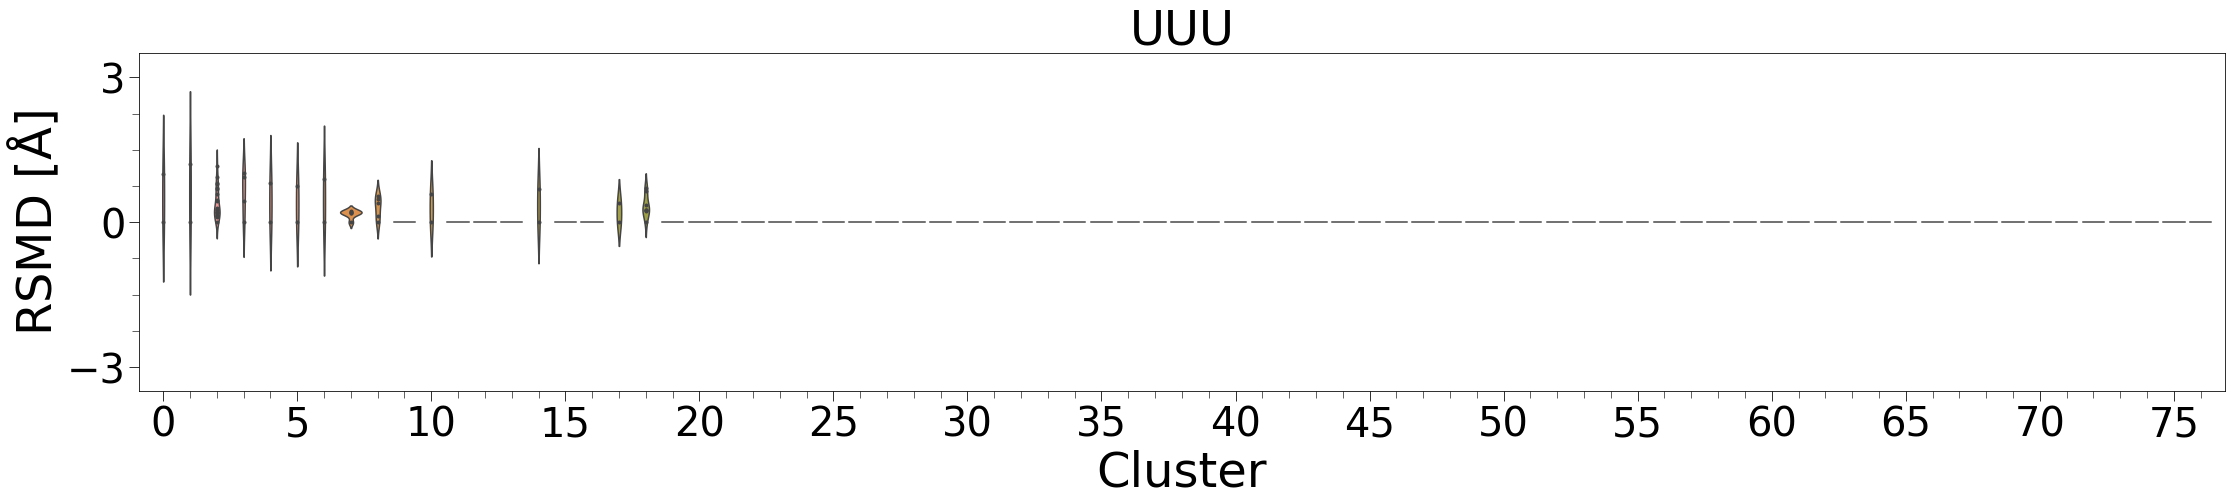

In [19]:
if __name__ == "__main__":
    
    base_path = os.path.dirname(os.path.abspath("__file__")).strip('notebooks')
    output_path = os.path.join(base_path, "pdb", "motif", "cluster")
    dump_path = os.path.join(output_path, "dump")
    release_versions = [ "HairpinLoopMotifAtlasRelease3.57", "InternalLoopMotifAtlasRelease3.57", "nrlist_3.233_2.5A/JunctionLoop" ]
    
    os.makedirs(os.path.join(dump_path), exist_ok = True)      # dump directory to store removed structures
    
    #params = { "method": "ward", "threshold": 20 }      # minimizes the variance of the clusters being merged
    params = { "method": "average", "threshold": 0.9 }   # uses the average of the distances of each observation of the two sets --> BEST
    #params = { "method": "complete", "threshold": 2 }  # linkage uses the maximum distances between all observations of the two sets
    #params = { "method": "single", "threshold": 10 }    # uses the minimum of the distances between all observations of the two sets
        
    #categories = { "doublebase": 2, "triplebase": 3 }
    categories = { "triplebase": 3 }

    
    n_total = 0
    for category, n in categories.items():
        arr = get_basesets(categories)
        for seq in arr:
            
            dest_path = os.path.join(output_path, category, seq)
            os.makedirs(dest_path, exist_ok = True)

            _ = [ glob.glob(output_path.strip('cluster') + "/{}/{}/*_{}_*.pdb".format(release_version, category, seq)) for release_version in release_versions ]
            files = list(set([ item for elem in _ for item in elem ]))  # convert nested list into flat list
            print("{}: {} files found".format(seq, len(files)))

            # curate input files
            curated_files = load_file(files, dump_path)

            # calculate features
            feat_torsion = torsion_featurizer(curated_files)
            feat_dist = dist_featurizer(curated_files, atom_slice_interval=1)
            feat_concat = np.concatenate((feat_torsion, feat_dist), axis=1)

            #feat = feat_torsion
            feat = feat_dist
            #feat = feat_concat

            # feature scaling
            #scale = StandardScaler().fit_transform(feat)
            #pca = PCA(svd_solver="full")
            #pca.fit(scale)
            #pca_coord = pca.transform(scale)
            #print("# of components: {} -> {} / explained variance: {:.2f}".format(len(feat[1]), pca.n_components_, pca.explained_variance_ratio_.sum()))

            # clustering
            X = feat
            cluster_labels, centroid_indexes = agglomerative_cluster(X, params)
            #cluster_labels, centroid_indexes = dbscan_cluster(X, params)

            # export cluster centroids
            n = export_pdb(curated_files, cluster_labels, centroid_indexes, dest_path)
            n_total += n

            # plot rmsd distribution
            cluster_path = os.path.join(output_path, category, seq)
            plot(cluster_path, seq)
                
                
    print("=======================")
    print("total structures: {}".format(n_total))

In [ ]:
#feat.shape

In [ ]:
#feat[0]

In [ ]:
#scale